In [1]:
!pip install argparse numpy pygame
!git clone 'https://github.com/Maluuba/jumping-task.git'
!pip install -e jumping-task/gym-jumping-task/

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Cloning into 'jumping-task.git''...
fatal: protocol ''https' is not supported
ERROR: jumping-task/gym-jumping-task/ is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [1]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Grayscale, ToPILImage

# Auxiliary Python imports
from scipy import spatial
import numpy as np
import pickle as pkl
import bz2
from tqdm.notebook import tqdm
from matplotlib import pylab as P, pyplot as plt
from matplotlib import colors
from collections import namedtuple


import umap
import umap.plot

## Gym imports
import gym
import gym_jumping_task

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rendering = not torch.cuda.is_available()
print(device)

cpu


## Auxiliary Functions

In [3]:
DEFAULT_SEED = np.sum([ord(c) for c in "Generalization"])
def reset_rng(seed = None):
    if seed is None:
        seed = DEFAULT_SEED
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
def plot(data, xdata=None, xlab="", ylab="", title="", markers=None, window=50):
    def moving_average_std():
        means = np.zeros(len(data))
        stds = np.zeros(len(data))
        for i in range(len(data)):
            window_data = data[max(0, i - window) : min(len(data)-1, i)+1]
            means[i] = np.mean(window_data)
            stds[i] = np.std(window_data)
        return means, stds
    
    
    means, stds = moving_average_std()

    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    if xdata is None:
        plt.fill_between(np.arange(len(data)), means - stds, means + stds, color='g', alpha=0.2)
        plt.plot(means)
        plt.plot(data, alpha=0.3, c='r')
    else:
        plt.fill_between(xdata, means - stds, means + stds, color='g', alpha=0.2)
        plt.plot(xdata,means)
        plt.plot(xdata, data, alpha=0.3, c='r')
    
    if markers is not None:
        pos, info = markers
        pos = np.array(pos)
        if type(info) is str:
            if info == "vline":
                plt.vlines(pos, ymin=np.amin(data), ymax=np.amax(data), colors='black', alpha=0.5)
        else:
            plt.plot(pos[:, 0], pos[:, 1], marker='o', linestyle='None')
            for i in range(len(info)):
                plt.annotate(info[i], pos[i], xytext=(-5,5), textcoords='offset pixels')
    
    plt.show()

In [5]:
def plot_mean_std(xdata, ydata, xlab="", ylab="", title="", markers=None, window=50):
    
    means = np.zeros(len(xdata))
    stds = np.zeros_like(means)
    
    for i, x in enumerate(xdata):
        means[i] = np.mean(ydata[i])
        stds[i] = np.std(ydata[i])
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    plt.fill_between(xdata, means - stds, means + stds, color='g', alpha=0.2)
    plt.plot(xdata,means)
    #plt.plot(xdata, data, alpha=0.3, c='r')
    
    if markers is not None:
        pos, info = markers
        pos = np.array(pos)
        if type(info) is str:
            if info == "vline":
                plt.vlines(pos, ymin=np.amin(data), ymax=np.amax(data), colors='black', alpha=0.5)
        else:
            plt.plot(pos[:, 0], pos[:, 1], marker='o', linestyle='None')
            for i in range(len(info)):
                plt.annotate(info[i], pos[i], xytext=(-5,5), textcoords='offset pixels')
    
    plt.show()

In [6]:
def plot_results(results, training_settings, export_path=None):
    #plt.imshow(results)
    #cmap = colors.LinearSegmentedColormap.from_list("Custom",['#333333','#FAEADC'], N=100)
    plt.figure(figsize=(RANGE_OBSTACLE_POSITION/2,RANGE_FLOOR_HEIGHT/2))
    plt.pcolor(results[::-1],cmap='gray',edgecolors='#fc9f5d', linewidths=0.5, vmin=0, vmax=1.0)
    plt.colorbar()
    for t in training_settings:
        plt.annotate('T', (t['obstacle_position'] - OBSTACLE_MIN_POSITION, t['floor_height']), color='r', textcoords="offset points", xytext=(10, 10), fontsize='large', fontweight='bold', ha='center')
    plt.xlabel("Obstacle Position")
    plt.ylabel("Floor Height")
    if export_path is None:
        plt.show()
    else:
        plt.savefig(export_path)

## Testing the environment

In [7]:
gym.make('jumping-task-v0')
env = gym_jumping_task.envs.JumpTaskEnv()
ACTION_SPACE = env.nb_actions
STATE_SIZE = np.prod(env.state_shape)
floor_height = 10
obstacle_pos = 30
state = env._reset(floor_height=floor_height, obstacle_position=obstacle_pos)

c:\Users\sarrg\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (60, 60)
  logger.warn(


In [8]:
print(STATE_SIZE)

3600


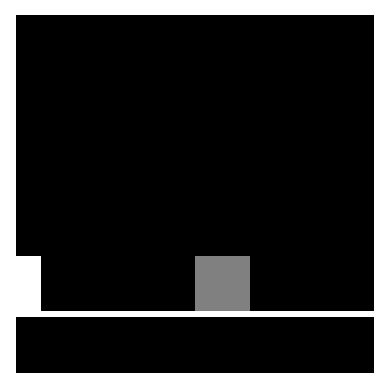

In [9]:
plt.axis('off')
plt.imshow(state, cmap='gray', origin='lower')

## Define Expert policy

In [10]:
class Expert():
    def __init__(self, env: gym_jumping_task.envs.JumpTaskEnv):
        self.env = env
    
    def select_action(self, state=None):
        if self.env.agent_pos_x + 14 == self.env.obstacle_position:
            return 1
        return 0

Score: 57
Game Won


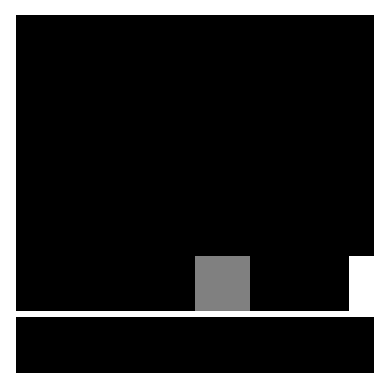

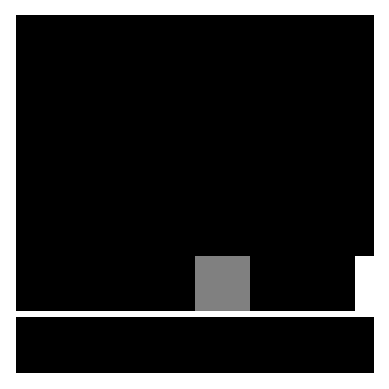

In [11]:
state = env.reset()
expert = Expert(env)
done = False
score = 0
prev_state = None
while not done:
    prev_state = state
    a = expert.select_action()
    state, reward, done, _ = env.step(a)
    score += reward
print("Score:", score)
print("Game", "Won" if reward == 2 else "Lost")
plt.axis('off')
plt.imshow(prev_state, cmap='gray', origin='lower')
plt.show()
plt.axis('off')
plt.imshow(state, cmap='gray', origin='lower')
plt.show()

## Generate and store demonstrations played by the expert

In [12]:
#Transition = namedtuple('Transition', ['state', 'action', 'rewards', 'next_state', 'done'])
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class Episode(object):
    def __init__(self):
        self.transitions = []
        
    def __len__(self):
        return len(self.transitions)
    
    def append(self, transition):
        self.transition.append(transition)
        
    def __getitem__(self, index):
        return self.transitions[index]


class ReplayBuffer(object):
    def __init__(self, capacity=0):
        self.buffer = []
        self._next = 0
        self.capacity = int(capacity)
    
    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        return self.buffer[index]
    
    def add_episode(self, episode):
        if self.capacity != 0 and len(self) == self.capacity:
            for t in episode:
                self.buffer[self._next] = t
                self._next = (self._next+1)%self.capacity
        else:
            cap = len(episode) if self.capacity == 0 else min(len(episode), self.capacity - len(self))
            self.buffer.extend(episode[0:cap])
    
    def add(self, transition: Transition):
        if self.capacity != 0 and len(self) == self.capacity:
            self.buffer[self._next] = transition
            self._next = (self._next+1)%self.capacity
        else:
            self.buffer.append(transition)
        
    def clear(self):
        self._next=0
        self.buffer.clear()
        
    def save(self, path):
        with bz2.open(path, "wb") as f:
            f.write(pkl.dumps(self.buffer))
    
    def load(self, path):
        with bz2.open(path, "rb") as f:
            self.buffer = pkl.loads(f.read())


In [13]:
n_episodes = 250

env = gym_jumping_task.envs.JumpTaskEnv()
expert = Expert(env)
buffer = ReplayBuffer()
for e in tqdm(range(n_episodes)):
    episode = []
    env.reset()
    done = False
    while not done:
        a = expert.select_action()
        next_state, reward, done, _ = env.step(a)
        episode.append(Transition(state, a, reward, next_state, done))
        state = next_state
    if reward == -1:
        print("[WARN] GAME LOST")
    buffer.add_episode(episode)
#buffer.save("demonstrations.bz2")
print("Transitions:", len(buffer))

  0%|          | 0/250 [00:00<?, ?it/s]

Transitions: 14000


## Create Dataset

In [14]:
class BufferDataset(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer

    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        sample = self.buffer[index]
        state = torch.tensor(sample.state).unsqueeze(dim=0)
        next_state = torch.tensor(sample.next_state).unsqueeze(dim=0)
        reward = torch.tensor(sample.reward)
        _action = sample.action
        action = torch.zeros(ACTION_SPACE)
        action[_action] = 1.0
        done = torch.tensor(float(sample.done))
        return state.float().to(device), action.float().to(device), reward.float().to(device), next_state.float().to(device), done.float().to(device)

In [15]:
dataset = BufferDataset(buffer)
print(dataset.__getitem__(0))

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor([1., 0.]), tensor(1.), tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor(0.))


## Define Agent and Policy Network

In [16]:
class AgentNetwork(nn.Module):
    def __init__(self, n_action_space):
        super(AgentNetwork, self).__init__()
        
        # based on LeNet
        self.c1 = torch.nn.Conv2d(1, 6, 5)
        self.s2 = torch.nn.MaxPool2d(4)
        self.c3 = torch.nn.Conv2d(6, 16, 5)
        self.s4 = torch.nn.MaxPool2d(2)
        self.c5 = torch.nn.Conv2d(16, 120, 5)
        self.f6 = torch.nn.Linear(120, n_action_space*5)
        #self.d7 = torch.nn.Dropout(0.15)
        self.out = torch.nn.Linear(n_action_space*5, n_action_space)

    def forward(self, x):
        x = torch.relu(self.c1(x))
        x = self.s2(x)
        x = torch.relu(self.c3(x))
        x = self.s4(x)
        x = torch.relu(self.c5(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.f6(x))
        #x = self.d7(x)
        return self.out(x)

class Agent():
    def __init__(self, model, name = "Agent"):
        self.name = name
        self.model = model
        pass
    
    @staticmethod
    def transform(state):
        return torch.tensor(state).float().to(device).unsqueeze(0).unsqueeze(0)
    
    @torch.no_grad()
    def act(self, state):
        self.model.eval()
        state = self.transform(state)
        actions = self.model(state).squeeze()
        return torch.argmax(actions).item()
    
    def save(self, info=None):
        if info is not None:
            info = '_' + info
        else:
            info = ''
        torch.save(self.model.state_dict(), f'models/{self.name}{info}.pth')
        
    def load(self, info=None):
        if info is not None:
            info = '_' + info
        else:
            info = ''
        self.model.load_state_dict(torch.load(f'models/{self.name}{info}.pth'))

## Training the Agent

In [17]:
class BCTrainer():
    """Behavioral Cloning Trainer class
    """
    
    def __init__(self, model, dataloader, loss_func, optimizer, validation=False):
        self.model = model
        self.dataloader = dataloader
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.validation = validation
        
    def train(self, updates = None, pbar=None, show_progress=True):
        self.model.train()
        if show_progress and pbar is None:
            pbar = tqdm(range(1))
        
        losses = []
        loader_len = len(self.dataloader)
        for i, (states, actions, _, _, _) in enumerate(self.dataloader):
            self.optimizer.zero_grad()
            pred = self.model(states)
            loss = self.loss_func(pred, actions)
            loss.backward()
            self.optimizer.step()

            losses.append(loss.item())
            if show_progress:
                pbar.set_postfix_str(f"[{i+1}/{loader_len}] Loss: {losses[-1]:.4f}")
            if updates is not None:
                updates -=1
                if updates == 0:
                    break
        return losses
    
    def eval(self, mode='dataset'):
        self.model.eval()
        
        if mode == 'dataset':
            losses = []
            loader_len = len(self.dataloader)
            for i, (states, actions, _, _, _) in enumerate(self.dataloader):
                pred = self.model(states)
                loss = self.loss_func(pred, actions)
                losses.append(loss.item())
            return losses
        
        if mode == 'all_episodes':
            _agent = Agent(self.model)
            _, winrate = evaluate_agent_on_all_episodes(_agent, verbose=False)
            return winrate
            
    def run(self, epochs, updates=None, show_progress=True):
        win_rates = None
        all_losses = []
        all_losses.extend(self.eval())
        
        if self.validation:
            win_rates = np.zeros(epochs+1)
            win_rates[0] = self.eval(mode = 'all_episodes')
        
        pbar = range(1, epochs+1 if updates is None else updates+1)
        if show_progress:
            pbar = tqdm(pbar) 
        
        for e in pbar:
            losses = self.train(updates, pbar, show_progress)
            all_losses.extend(losses)
            if self.validation:
                win_rates[e] = self.eval(mode = 'all_episodes')
            
            if updates is not None:
                updates -= len(losses)
                if updates == 0:
                    break
        return all_losses, win_rates if self.validation else None

In [18]:
lr = 1e-3
batchsize = 250
n_epochs = 10

In [18]:
reset_rng()

net = AgentNetwork(ACTION_SPACE).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)

loader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

trainer = BCTrainer(net, loader, loss_func, optimizer)

In [19]:
losses, _ = trainer.run(n_epochs)


  0%|          | 0/10 [00:00<?, ?it/s]

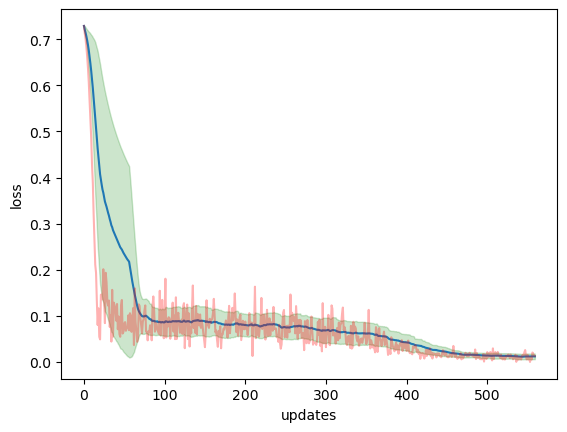

Text(0, 0.5, 'loss')

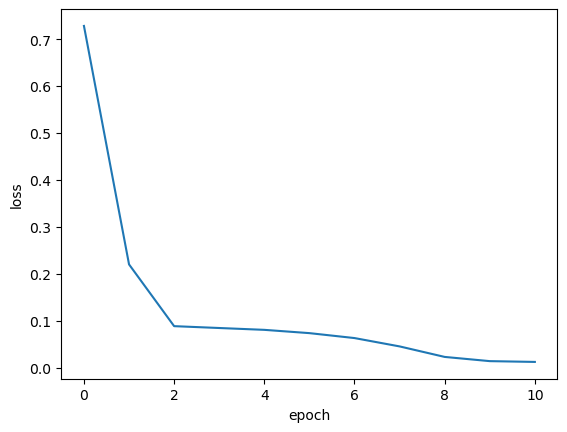

In [21]:
losses_per_epoch = len(losses) // (n_epochs + 1)

markers = []
markers = ([[losses_per_epoch*(i-1), losses[losses_per_epoch*i]] for i in range(1, n_epochs + 1)])
#markers.append([f"Ep{i}" for i in range(n_epochs)])

plot(losses[losses_per_epoch:], "updates", "loss", window=losses_per_epoch)
plt.plot(np.mean(np.split(np.array(losses), n_epochs+1), axis=-1))
plt.xlabel("epoch")
plt.ylabel("loss")

## Evaluation of Behavioral Cloning Agent

In [19]:
def evaluate_agent(env, agent):
    state = env.get_state()
    done = False
    reward = 0
    while not done:
        a = agent.act(state)
        state, reward, done, _ = env.step(a)
    return reward == 2

In [20]:
def evaluate_on_random_episodes(env, agent, n_episodes=50):
    won = 0
    print(agent.name)
    with tqdm(range(n_episodes)) as pbar:
        for e in pbar:
            env.reset()
            won += int(evaluate_agent(env, agent))
            pbar.set_postfix_str(f"Won: {won}/{n_episodes}")
    env.close()
    return won / n_episodes

#### Evaluate on different seed

In [ ]:
n_episodes = 100
env = gym_jumping_task.envs.JumpTaskEnv(rendering=rendering, seed=8)
agent = Agent(net)
wl_ratio = evaluate_on_random_episodes(env, agent, n_episodes)
print(f"{wl_ratio*100}% of games won")

## Testing with different Demonstration Samplings

In [21]:
OBSTACLE_MAX_POSITION = 40-1
OBSTACLE_MIN_POSITION = 14
RANGE_OBSTACLE_POSITION = OBSTACLE_MAX_POSITION - OBSTACLE_MIN_POSITION
RANGE_FLOOR_HEIGHT = 10
MAX_SAMPLES = (RANGE_OBSTACLE_POSITION + 1) * (RANGE_FLOOR_HEIGHT + 1)
n_samples = 18

In [22]:
lr = 1e-3
batchsize = 128
wd = 1e-5
n_epochs = 100

In [23]:
def evaluate_agent_on_all_episodes(agent, verbose = False):
    env = gym_jumping_task.envs.JumpTaskEnv(rendering=verbose, seed=8)
    results = np.zeros((RANGE_FLOOR_HEIGHT+1, RANGE_OBSTACLE_POSITION+1))
    
    pbar = None
    if verbose:
        print(agent.name)
        pbar = tqdm(total=MAX_SAMPLES)
    
    won = 0
    for floor_height in range(RANGE_FLOOR_HEIGHT+1):
        for obstacle_pos in range(OBSTACLE_MIN_POSITION, OBSTACLE_MAX_POSITION+1):
            env._reset(obstacle_position=obstacle_pos, floor_height=floor_height)
            result = int(evaluate_agent(env, agent))
            results[RANGE_FLOOR_HEIGHT - floor_height, obstacle_pos - OBSTACLE_MIN_POSITION] = result
            won += result
            if pbar is not None:
                pbar.set_postfix_str(f"Won: {won}/{MAX_SAMPLES}")
                pbar.update()
    env.close()
    return results, won / MAX_SAMPLES

In [24]:
def test_sampling_strategy(demonstrations: ReplayBuffer, agent_name="Agent", validation=False, silent=False, n_runs=1, updates=None, redo_fails=False, hyperparameters={}):
    
    dataset = BufferDataset(demonstrations)
    results = []

    pbar = range(n_runs)

    if not silent:
        pbar = tqdm(pbar)

    if n_runs > 10:
        silent = True

    def get_hp(hp_name, default):
        return hyperparameters[hp_name] if hp_name in hyperparameters else default

    _lr = get_hp('lr', lr)
    _batchsize = get_hp('batchsize', batchsize)
    _wd = get_hp('wd', wd)
    _n_epochs =  get_hp('n_epochs', n_epochs)
    seed = DEFAULT_SEED
    for i in pbar:
        done_run = False
        
        while not done_run:
        
            reset_rng(seed)
            seed = np.random.randint(DEFAULT_SEED)

            net = AgentNetwork(ACTION_SPACE).to(device)
            loss_func = nn.CrossEntropyLoss().to(device)
            optimizer = optim.Adam(net.parameters(), lr=_lr, weight_decay=_wd)

            loader = DataLoader(dataset, batch_size=_batchsize, shuffle=True)

            trainer = BCTrainer(net, loader, loss_func, optimizer, validation=validation and not silent)
    
            losses, win_rates = trainer.run(_n_epochs, updates=updates, show_progress = not silent)

            agent = Agent(net, agent_name)
            result, _ = evaluate_agent_on_all_episodes(agent, verbose=rendering and n_runs==1 and not silent)
            
            if not redo_fails or np.sum(result) > 0.0:
                results.append(result)
                done_run = True
            

    if not silent:
        plt.yscale('log')
        plot(losses, "updates", "loss (log scale)", window=len(loader))
    
    if not silent and win_rates is not None:
        plt.plot(win_rates)
        plt.show()
    results = np.stack(results, axis=0)
    return np.mean(results, axis=0), np.mean(results, axis=(1,2))


In [25]:
def sample_demonstrations(args_per_episodes, buffer = None, augement_reward_func=None, sample_zero_rewards=True, silent=False):
    env = gym_jumping_task.envs.JumpTaskEnv()
    expert = Expert(env)
    if buffer is None:
        buffer = ReplayBuffer()
    n_episodes = len(args_per_episodes)
    pbar = range(n_episodes)
    if not silent:
        pbar=tqdm(pbar)
    
    for e in pbar:
        episode = []
        args = args_per_episodes[e]
        state = env._reset(**args)
        done = False
        while not done:
            action = expert.select_action()
            next_state, reward, done, _ = env.step(action)
            if augement_reward_func is not None:
                reward = augement_reward_func(env,reward,action)
            
            if reward != 0 or sample_zero_rewards:
                episode.append(Transition(state, action, reward, next_state, done))
            state = next_state
        if reward == -1:
            print("[WARN] GAME LOST")
        buffer.add_episode(episode)
    env.close()
    if not silent:
        print("Transitions:", len(buffer))
    return buffer

In [26]:
def sample_settings(n_samples, offset = 0, spacing = 4, samples_per_row = 6):
    settings = []
    if type(offset) is int:
        offset = (offset, offset)
    
    if type(spacing) is int:
        spacing = (spacing, spacing)
        
    for floor_height in range(offset[1], RANGE_FLOOR_HEIGHT+1, spacing[1]+1):
        row_samples = 0
        for obstacle_pos in range(OBSTACLE_MIN_POSITION + offset[0], OBSTACLE_MAX_POSITION+1, spacing[0]+1):
            settings.append({
                'floor_height': RANGE_FLOOR_HEIGHT - floor_height,
                'obstacle_position': obstacle_pos
            })
            row_samples += 1
            if row_samples == samples_per_row:
                break
        if len(settings) == n_samples:
            break
    return settings

In [27]:
all_sample_settings = sample_settings(1000, 0, 0, 1000)
print(len(all_sample_settings))

286


### Wide Sampling
```
T * * T * * T
* * * * * * *
* * * * * * *
T * * T * * T
* * * * * * *
* * * * * * *
T * * T * * T
```

In [58]:
wide_sampling_settings = sample_settings(n_samples, offset=(0,0), spacing=(4,4), samples_per_row=6)
print(wide_sampling_settings)

[{'floor_height': 10, 'obstacle_position': 14}, {'floor_height': 10, 'obstacle_position': 19}, {'floor_height': 10, 'obstacle_position': 24}, {'floor_height': 10, 'obstacle_position': 29}, {'floor_height': 10, 'obstacle_position': 34}, {'floor_height': 10, 'obstacle_position': 39}, {'floor_height': 5, 'obstacle_position': 14}, {'floor_height': 5, 'obstacle_position': 19}, {'floor_height': 5, 'obstacle_position': 24}, {'floor_height': 5, 'obstacle_position': 29}, {'floor_height': 5, 'obstacle_position': 34}, {'floor_height': 5, 'obstacle_position': 39}, {'floor_height': 0, 'obstacle_position': 14}, {'floor_height': 0, 'obstacle_position': 19}, {'floor_height': 0, 'obstacle_position': 24}, {'floor_height': 0, 'obstacle_position': 29}, {'floor_height': 0, 'obstacle_position': 34}, {'floor_height': 0, 'obstacle_position': 39}]


In [59]:
wide_demonstrations = sample_demonstrations(wide_sampling_settings)


  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


In [60]:
wide_results_per_sample, wide_results_per_run = test_sampling_strategy(wide_demonstrations, "Wide Agent", n_runs=25, redo_fails=True)

  0%|          | 0/25 [00:00<?, ?it/s]

In [83]:
print(wide_results_per_run)

[0.34965035 0.32167832 0.20629371 0.33566434 0.23076923 0.28671329
 0.31118881 0.33566434 0.27272727 0.05244755 0.23776224 0.22027972
 0.17832168 0.26573427 0.17482517 0.32867133 0.32167832 0.51748252
 0.18881119 0.32867133 0.26923077 0.25874126 0.16083916 0.17482517
 0.18881119]


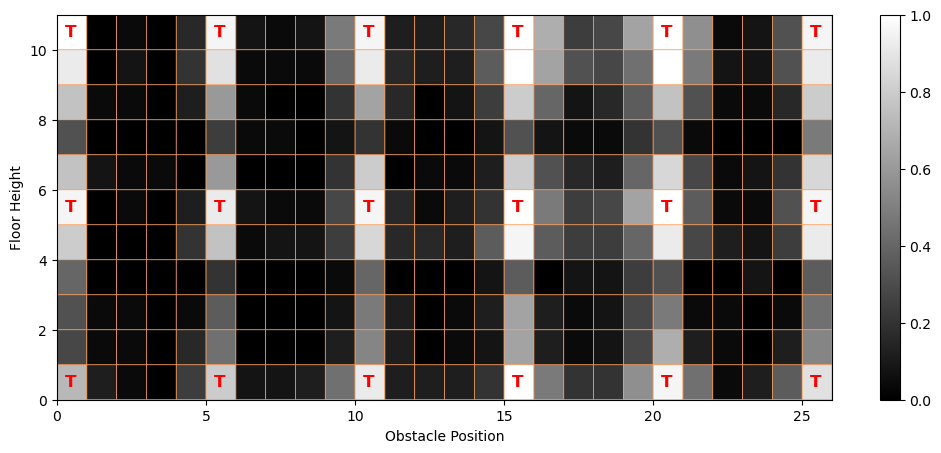

Estimated Winrate: 26.1% (+- 8.9%)


In [61]:
plot_results(wide_results_per_sample, wide_sampling_settings)
print(f"Estimated Winrate: {np.sum(wide_results_per_sample) / wide_results_per_sample.size *100:.1f}% (+- {np.std(wide_results_per_run)*100:.1f}%)")

### Narrow Sampling
```
* * * * * * *
* T * T * T *
* * * * * * *
* T * T * T *
* * * * * * *
* T * T * T *
* * * * * * *
```

In [62]:
narrow_sampling_settings = sample_settings(n_samples, offset=(8,3), spacing=1, samples_per_row=6)
print(narrow_sampling_settings)

[{'floor_height': 7, 'obstacle_position': 22}, {'floor_height': 7, 'obstacle_position': 24}, {'floor_height': 7, 'obstacle_position': 26}, {'floor_height': 7, 'obstacle_position': 28}, {'floor_height': 7, 'obstacle_position': 30}, {'floor_height': 7, 'obstacle_position': 32}, {'floor_height': 5, 'obstacle_position': 22}, {'floor_height': 5, 'obstacle_position': 24}, {'floor_height': 5, 'obstacle_position': 26}, {'floor_height': 5, 'obstacle_position': 28}, {'floor_height': 5, 'obstacle_position': 30}, {'floor_height': 5, 'obstacle_position': 32}, {'floor_height': 3, 'obstacle_position': 22}, {'floor_height': 3, 'obstacle_position': 24}, {'floor_height': 3, 'obstacle_position': 26}, {'floor_height': 3, 'obstacle_position': 28}, {'floor_height': 3, 'obstacle_position': 30}, {'floor_height': 3, 'obstacle_position': 32}]


In [63]:
narrow_sampling_demonstrations = sample_demonstrations(narrow_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


In [64]:
narrow_results_per_sample, narrow_results_per_run = test_sampling_strategy(narrow_sampling_demonstrations, "Narrow Agent", n_runs=25, redo_fails=True)

  0%|          | 0/25 [00:00<?, ?it/s]

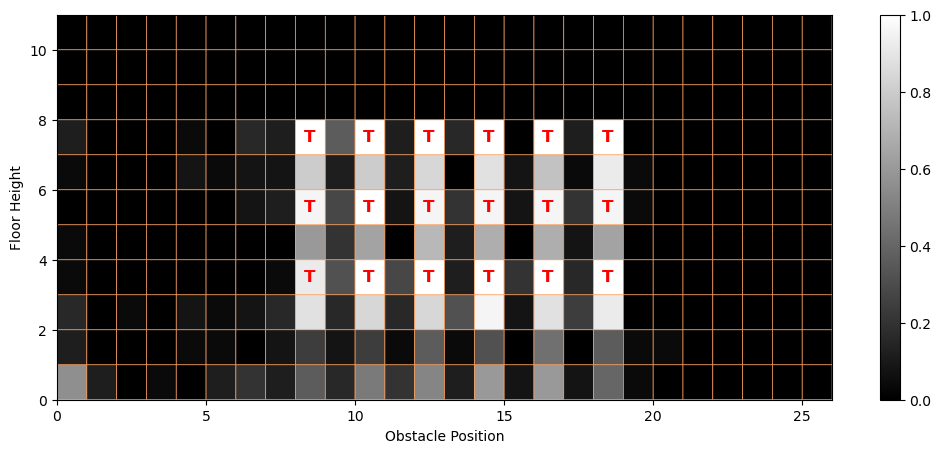

Estimated Winrate: 15.9% (+- 3.0%)


In [65]:
plot_results(narrow_results_per_sample, narrow_sampling_settings)
print(f"Estimated Winrate: {np.sum(narrow_results_per_run) / narrow_results_per_run.size *100:.1f}% (+- {np.std(narrow_results_per_run)*100:.1f}%)")

### Random Sampling
```
* T * * * T *
* * T * * * *
* * * * * * *
* T * T * * *
* * * * T * *
* * * * * T T
* * T * * * *
```

In [28]:
def random_settings(n_samples):
    settings = []
    rnds = np.random.choice(MAX_SAMPLES, size=n_samples, replace=False)
    for n in rnds:
        settings.append({
                'floor_height': n // (RANGE_OBSTACLE_POSITION+1),
                'obstacle_position': n % (RANGE_OBSTACLE_POSITION+1) + OBSTACLE_MIN_POSITION
        })
    return settings

In [29]:
reset_rng()
rnd_sampling_settings = random_settings(n_samples)
print(rnd_sampling_settings)

[{'floor_height': 5, 'obstacle_position': 15}, {'floor_height': 10, 'obstacle_position': 33}, {'floor_height': 10, 'obstacle_position': 18}, {'floor_height': 7, 'obstacle_position': 14}, {'floor_height': 4, 'obstacle_position': 29}, {'floor_height': 9, 'obstacle_position': 22}, {'floor_height': 6, 'obstacle_position': 27}, {'floor_height': 8, 'obstacle_position': 25}, {'floor_height': 5, 'obstacle_position': 38}, {'floor_height': 8, 'obstacle_position': 38}, {'floor_height': 4, 'obstacle_position': 24}, {'floor_height': 9, 'obstacle_position': 35}, {'floor_height': 10, 'obstacle_position': 23}, {'floor_height': 1, 'obstacle_position': 16}, {'floor_height': 3, 'obstacle_position': 36}, {'floor_height': 3, 'obstacle_position': 20}, {'floor_height': 9, 'obstacle_position': 19}, {'floor_height': 1, 'obstacle_position': 21}]


In [31]:
rnd_sampling_demonstrations = sample_demonstrations(rnd_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


In [ ]:
rnd_results_per_sample, rnd_results_per_run = test_sampling_strategy(rnd_sampling_demonstrations, "Random Sampling Agent", validation=False, n_runs=25, redo_fails=True)

  0%|          | 0/25 [00:00<?, ?it/s]

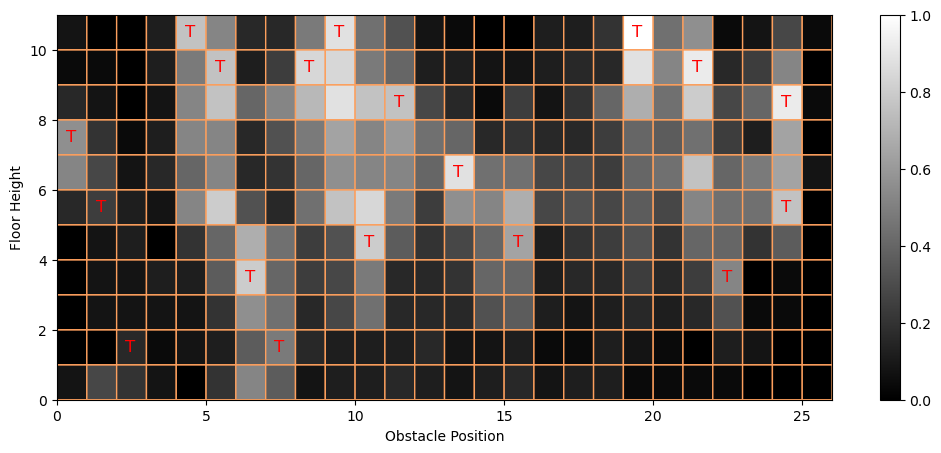

Estimated Winrate: 27.9% (+- 9.9%)


In [ ]:
plot_results(rnd_results_per_sample, rnd_sampling_settings)
print(f"Estimated Winrate: {np.sum(rnd_results_per_run) / rnd_results_per_run.size *100:.1f}% (+- {np.std(rnd_results_per_run)*100:.1f}%)")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Random Sampling Agent


  0%|          | 0/286 [00:00<?, ?it/s]

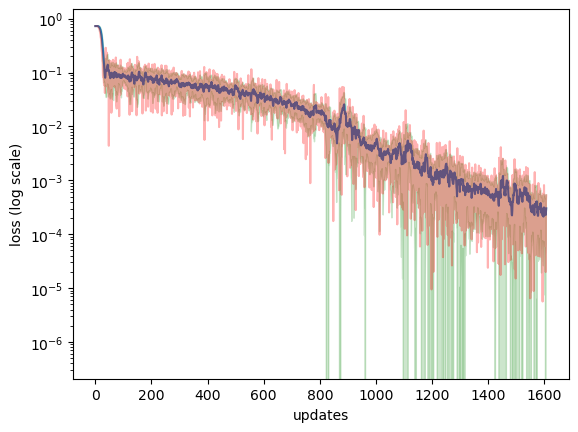

In [179]:
rnd_results_per_sample, rnd_results_per_run = test_sampling_strategy(rnd_sampling_demonstrations, "Random Sampling Agent", validation=False, n_runs=1)

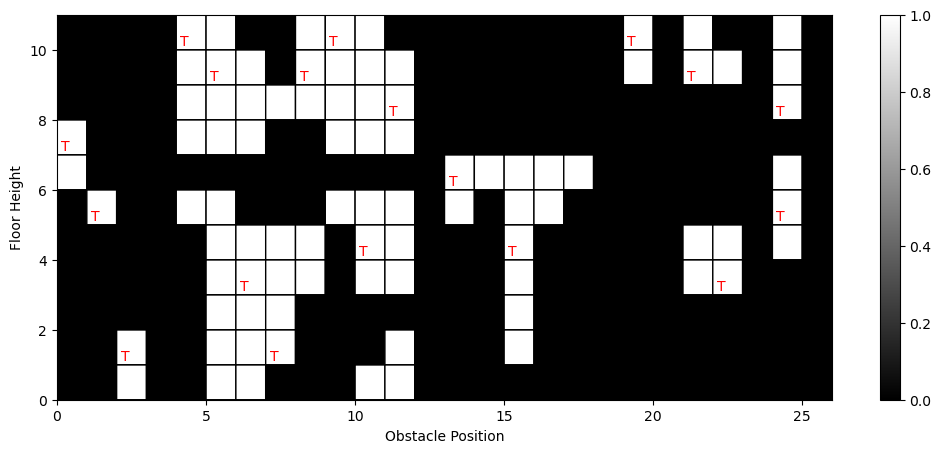

Estimated Winrate: 30.1%


In [180]:
plot_results(rnd_results, rnd_sampling_settings)
print(f"Estimated Winrate: {np.sum(rnd_results) / rnd_results.size *100:.1f}%")

### Mixed Sampling (Narrow and Wide)

In [ ]:
mixed_sampling_settings = []
adj_nss = sample_settings(n_samples, offset=(3,3), spacing=1, samples_per_row=6)
adj_nss = sample_settings(n_samples, offset=(5,2), spacing=2, samples_per_row=6)
for n in range(0, len(wide_sampling_settings), 6):
    if (n // 6 % 2) == 0:
        mixed_sampling_settings.extend(wide_sampling_settings[n:n+6])
    else:
        #mixed_sampling_settings.extend(narrow_sampling_settings[n:n+6])
        mixed_sampling_settings.extend(adj_nss[n:n+6])
print(mixed_sampling_settings)

NameError: name 'wide_sampling_settings' is not defined

In [ ]:
mixed_sampling_demonstrations = sample_demonstrations(mixed_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


In [ ]:
mixed_results_per_sample, mixed_results_per_run = test_sampling_strategy(mixed_sampling_demonstrations, "Mixed Sampling Agent", validation=False, n_runs=25, redo_fails=True)

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
plot_results(mixed_results_per_sample, mixed_sampling_settings)
print(f"Estimated Winrate: {np.sum(mixed_results_per_run) / mixed_results_per_run.size *100:.1f}% (+- {np.std(mixed_results_per_run)*100:.1f}%)")

NameError: name 'mixed_results_per_sample' is not defined

## Optimized Random Sampling
Instead of allowing any environment to be samples from, let us restrict that they are not allowed on to be on the highest and lowest floor heighest or lowest obstacle position, and not closer than 1.5 radius distance to other samples.

In [33]:
def optimized_random_settings(n_samples, offset, min_distance):
    settings = []
    rnds = []
    if type(offset) is int:
        offset = (offset,offset)
    
    available = [i for i in range(MAX_SAMPLES)]
    while len(rnds) < n_samples:
        n = available[np.random.randint(len(available))]
        candidate = [n % (RANGE_OBSTACLE_POSITION+1) + OBSTACLE_MIN_POSITION, n // (RANGE_OBSTACLE_POSITION+1)]
        
        if candidate[0] < OBSTACLE_MIN_POSITION + offset[0] or candidate[1] < offset[1] or candidate[0] > OBSTACLE_MAX_POSITION-offset[0] or candidate[1] > RANGE_FLOOR_HEIGHT-offset[1]:
            continue
        
        md = np.amin(np.sqrt(np.sum(np.square(np.array(rnds) - np.array(candidate)), axis=-1))) if len(rnds) else np.inf
        if md >= min_distance:
            available.remove(n)
            rnds.append(candidate)
        
    for r in rnds:
        settings.append({
            'floor_height': r[1],
            'obstacle_position': r[0]
        })
    return settings

In [35]:
optimized_sampling_settings = optimized_random_settings(n_samples, offset=(3,1), min_distance=2)
reset_rng()

print(optimized_sampling_settings)

[{'floor_height': 9, 'obstacle_position': 30}, {'floor_height': 3, 'obstacle_position': 25}, {'floor_height': 5, 'obstacle_position': 32}, {'floor_height': 1, 'obstacle_position': 31}, {'floor_height': 9, 'obstacle_position': 20}, {'floor_height': 7, 'obstacle_position': 22}, {'floor_height': 7, 'obstacle_position': 19}, {'floor_height': 6, 'obstacle_position': 30}, {'floor_height': 5, 'obstacle_position': 23}, {'floor_height': 2, 'obstacle_position': 28}, {'floor_height': 8, 'obstacle_position': 24}, {'floor_height': 7, 'obstacle_position': 26}, {'floor_height': 9, 'obstacle_position': 35}, {'floor_height': 6, 'obstacle_position': 34}, {'floor_height': 3, 'obstacle_position': 30}, {'floor_height': 1, 'obstacle_position': 34}, {'floor_height': 5, 'obstacle_position': 25}, {'floor_height': 5, 'obstacle_position': 28}]


In [37]:
optimized_sampling_demonstrations = sample_demonstrations(optimized_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


In [ ]:
optimized_results_per_sample, optimized_results_per_run = test_sampling_strategy(optimized_sampling_demonstrations, "Optimized Random Sampling Agent", validation=False, n_runs=25, redo_fails=True)

  0%|          | 0/25 [00:00<?, ?it/s]

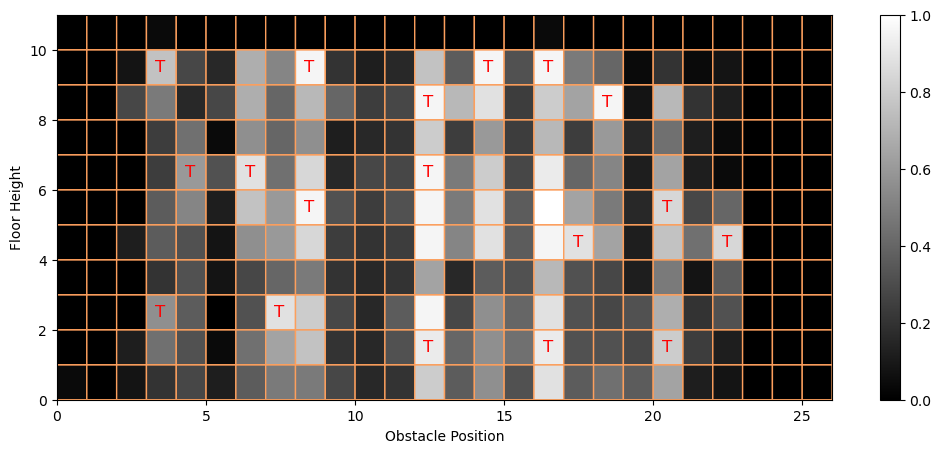

Estimated Winrate: 30.8% (+- 10.9%)


In [ ]:
plot_results(optimized_results_per_sample, optimized_sampling_settings)
print(f"Estimated Winrate: {np.sum(optimized_results_per_run) / optimized_results_per_run.size *100:.1f}% (+- {np.std(optimized_results_per_run)*100:.1f}%)")

## Hyperpararmeters (on Random)

In [30]:
reset_rng()
settings = random_settings(n_samples)
demonstrations = sample_demonstrations(settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


In [31]:
#default params
lr = 1e-3
epochs = 250
batchsize = 128
wd = 1e-5

### Epochs

  0%|          | 0/11 [00:00<?, ?it/s]

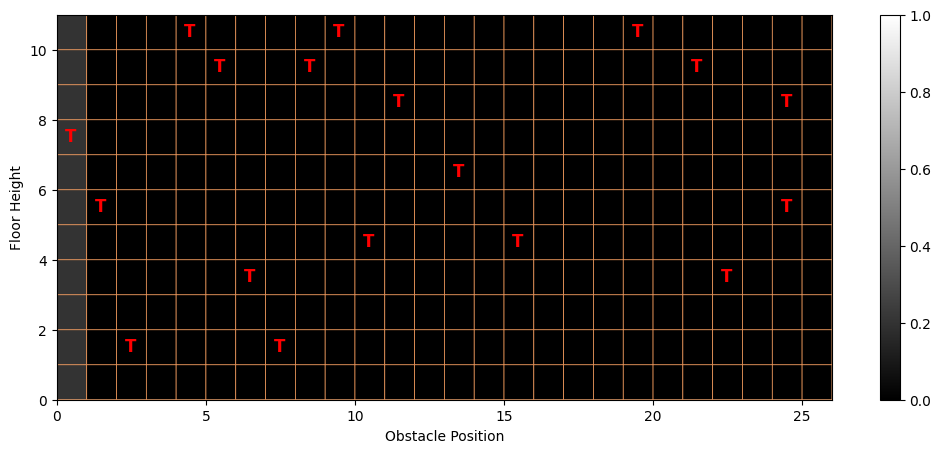

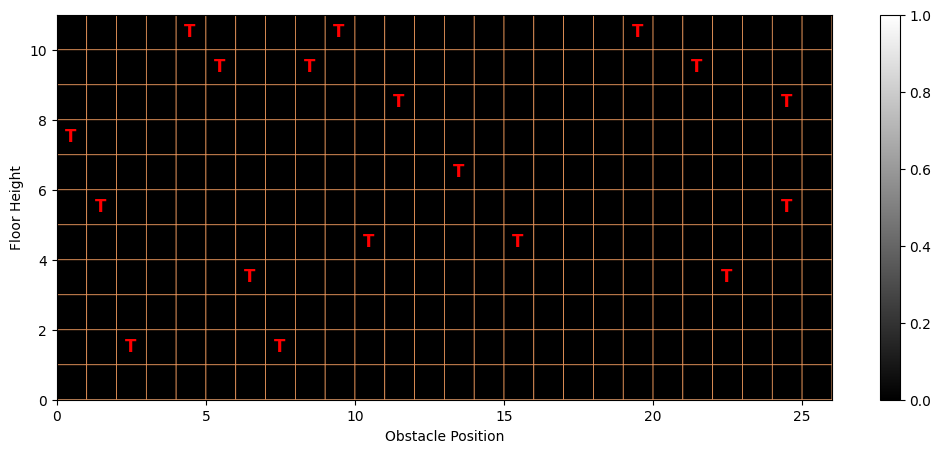

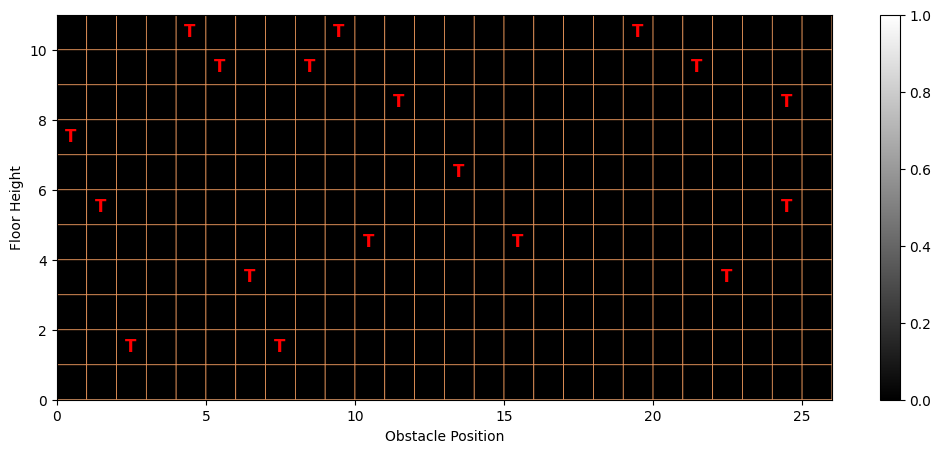

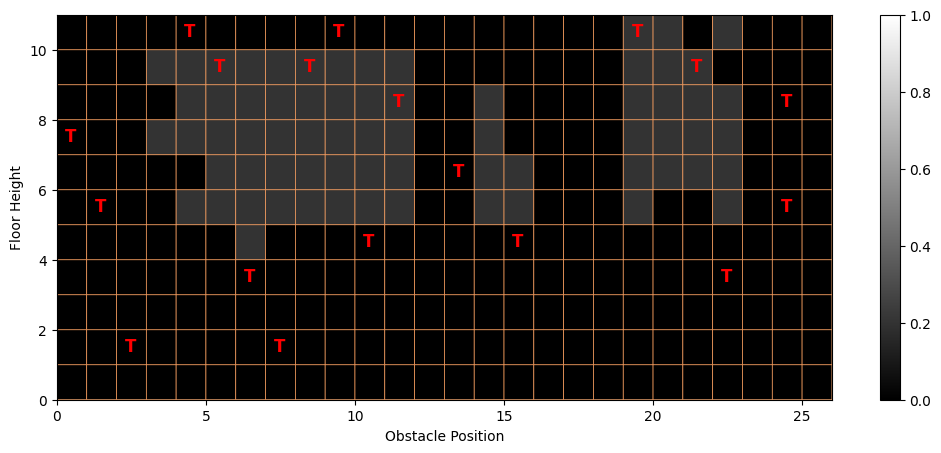

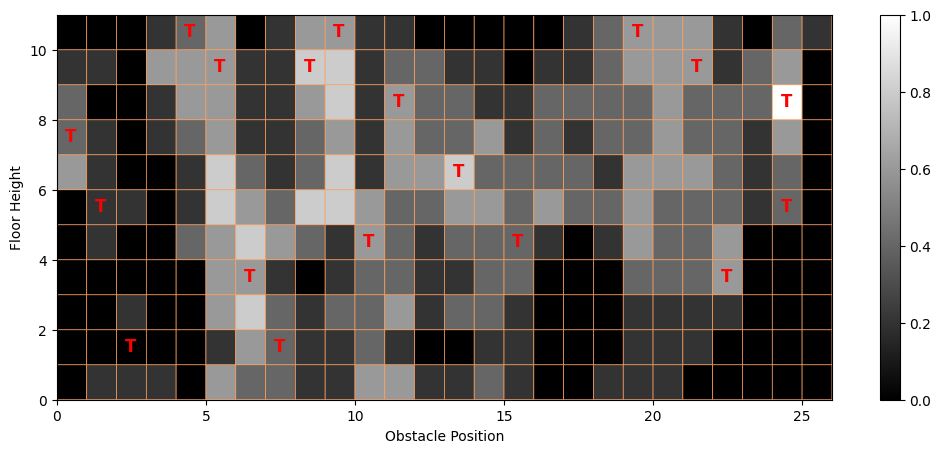

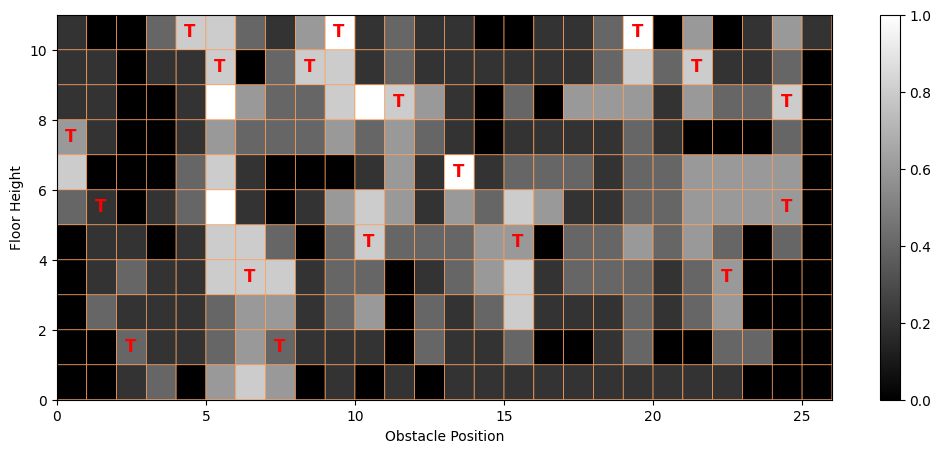

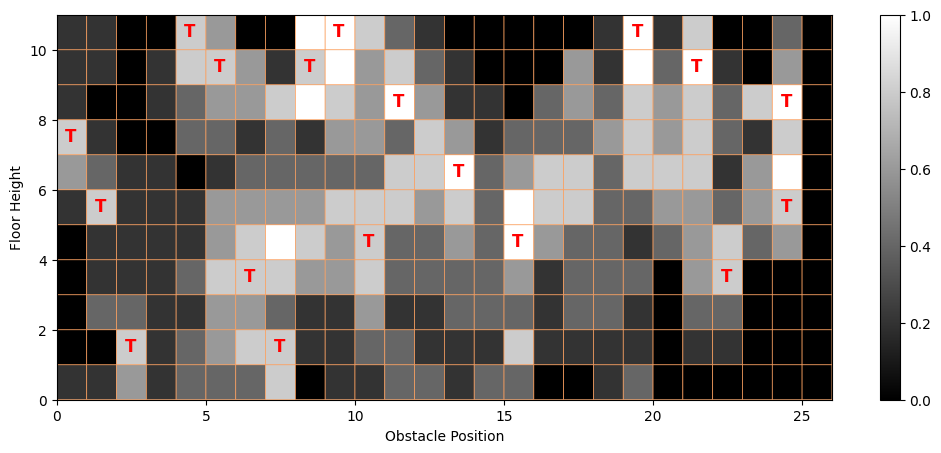

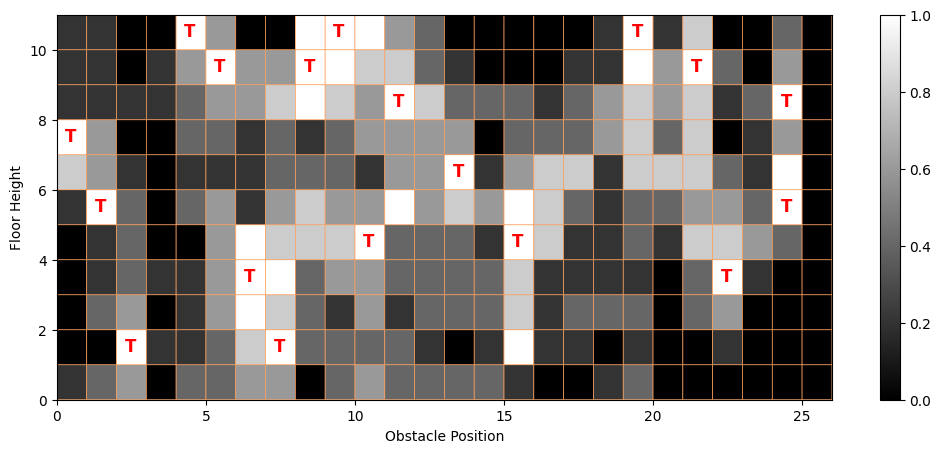

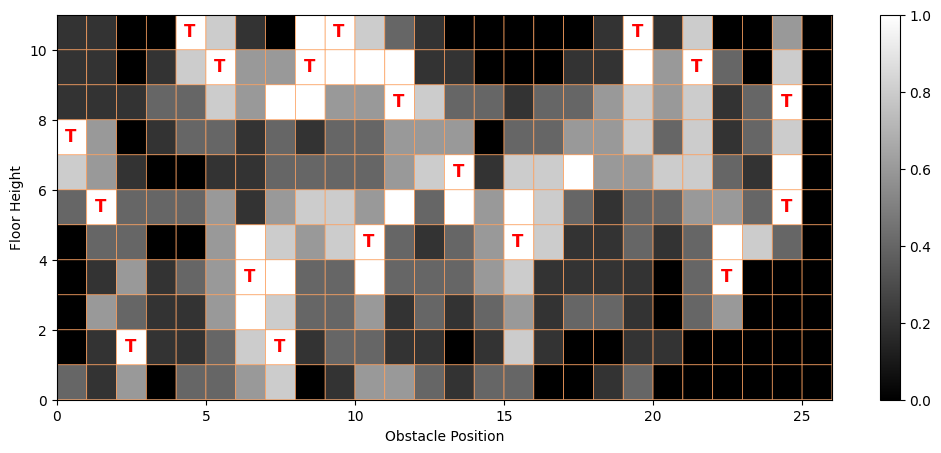

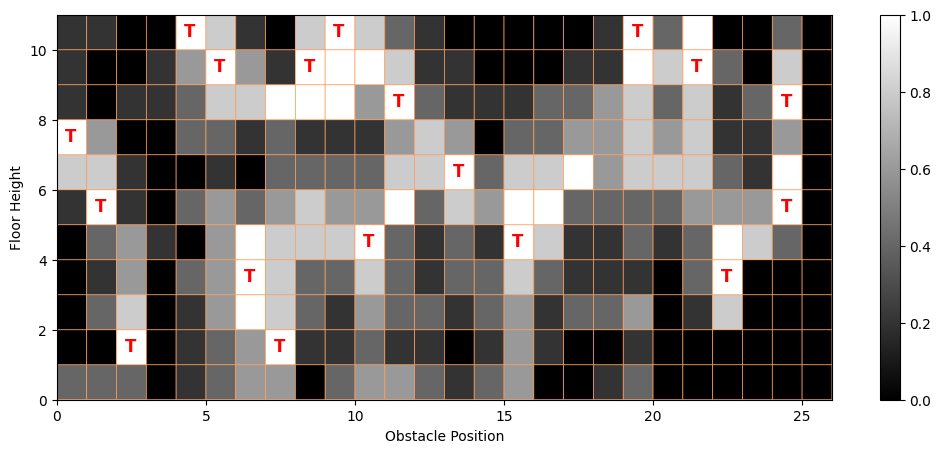

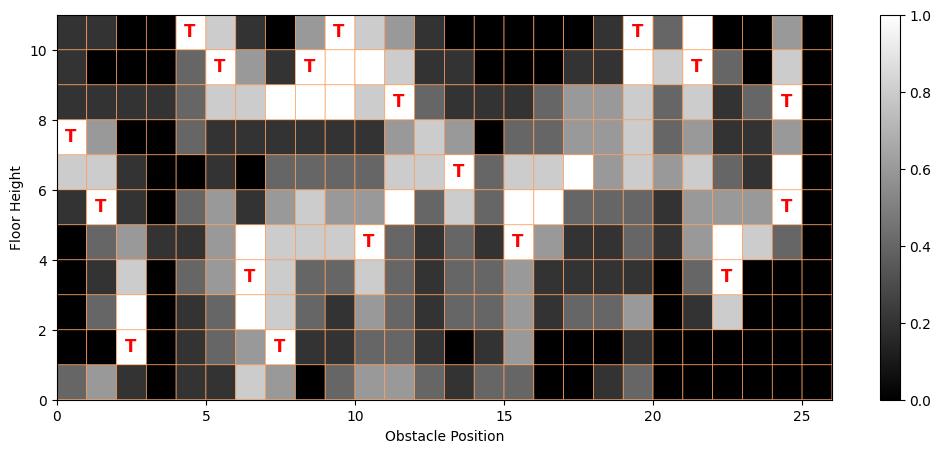

In [32]:
epochs = [1, 10, 25, 50, 75, 100, 150, 200, 250, 375, 500]
epochs_results = []
for i, e in enumerate(tqdm(epochs)):
    hyperparams = {'n_epochs': e}

    results_per_sample, results_per_run = test_sampling_strategy(demonstrations, "Random Sampling Agent", validation=False, silent=True, n_runs=5, hyperparameters=hyperparams, redo_fails=i>3)
    plot_results(results_per_sample, settings, export_path=f'figures/random_epochs_{e}.png')
    epochs_results.append(results_per_run)

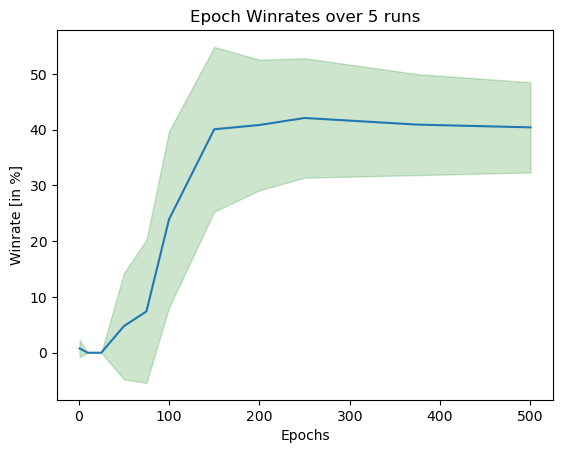

In [ ]:
plot_mean_std(epochs,np.array(epochs_results)*100, xlab="Epochs", ylab="Winrate [in %]", title="Epoch Winrates over 5 runs")

### Learning Rate

In [ ]:
lrs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
lrs_results = []
for i, _lr in enumerate(tqdm(lrs)):
    hyperparams = {'lr': _lr}

    results_per_sample, results_per_run = test_sampling_strategy(demonstrations, "Random Sampling Agent", validation=False, silent=True, n_runs=5, hyperparameters=hyperparams, redo_fails=(i==1 or i==2))
    plot_results(results_per_sample, settings, export_path=f'figures/random_lr_{_lr}.png')
    lrs_results.append(results_per_run)

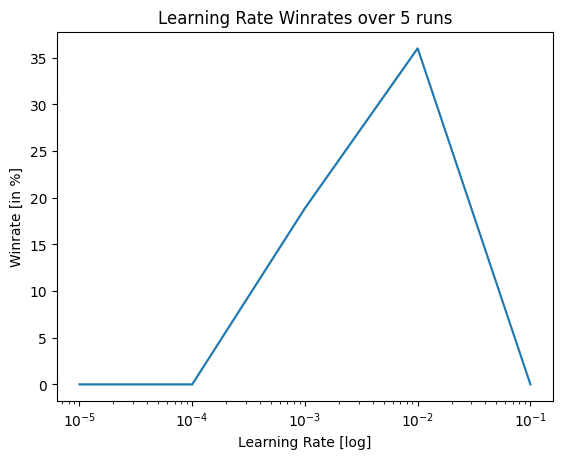

In [ ]:
plt.xscale('log')
plot_mean_std(lrs,np.array(lrs_results)*100, xlab="Learning Rate [log]", ylab="Winrate [in %]", title="Learning Rate Winrates over 5 runs")

### Weight Decay

In [ ]:
wds = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
wds_results = []
for i, _wd in enumerate(tqdm(wds)):
    hyperparams = {'wd': _wd}

    results_per_sample, results_per_run = test_sampling_strategy(demonstrations, "Random Sampling Agent", validation=False, silent=True, n_runs=5, hyperparameters=hyperparams, redo_fails=i>1)
    plot_results(results_per_sample, settings, export_path=f'figures/random_wd_{_wd}.png')
    wds_results.append(results_per_run)

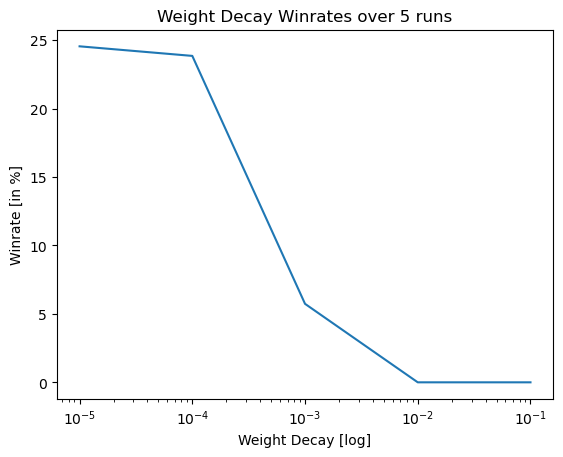

In [ ]:
plt.xscale('log')
plot_mean_std(wds, np.array(wds_results)*100, xlab="Weight Decay [log]", ylab="Winrate [in %]", title="Weight Decay Winrates over 5 runs")

### Batch Size

  0%|          | 0/4 [00:00<?, ?it/s]

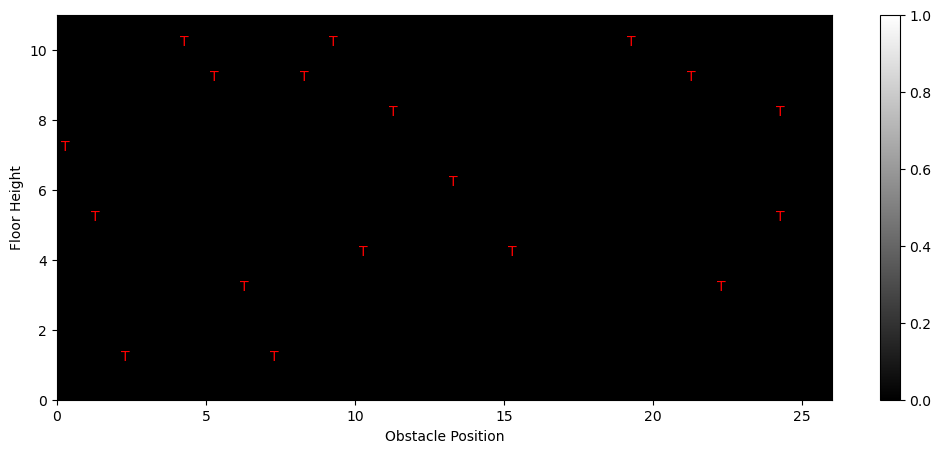

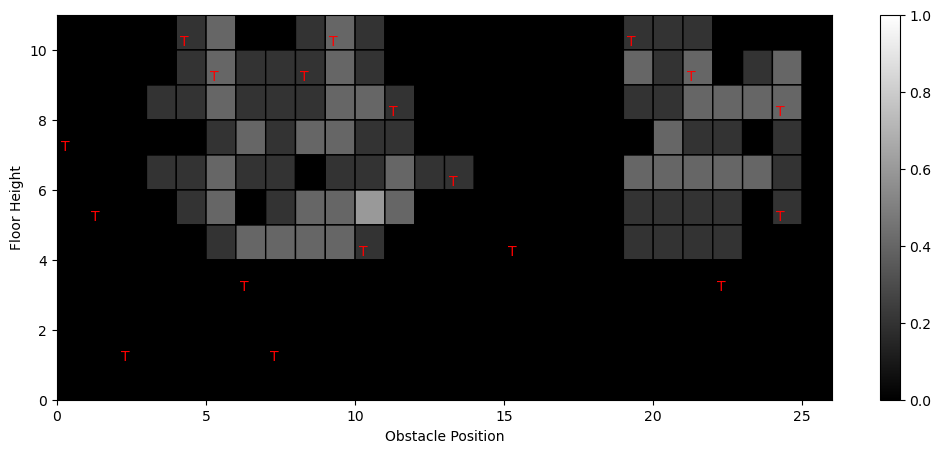

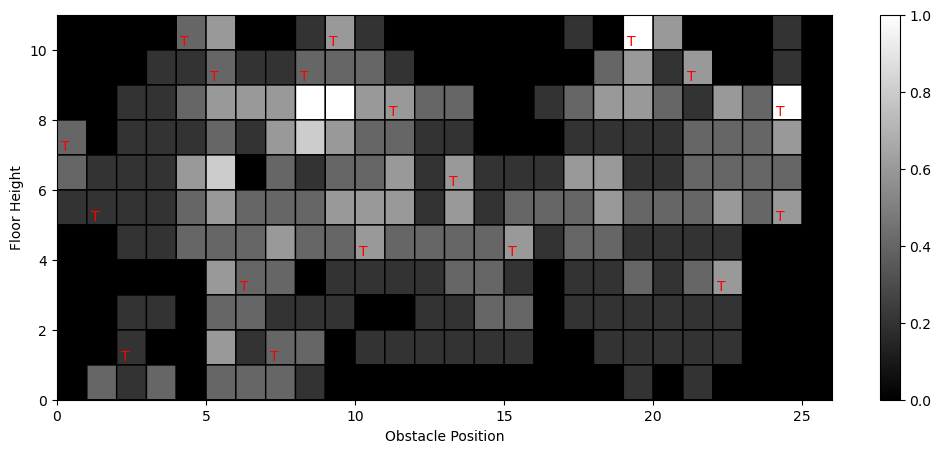

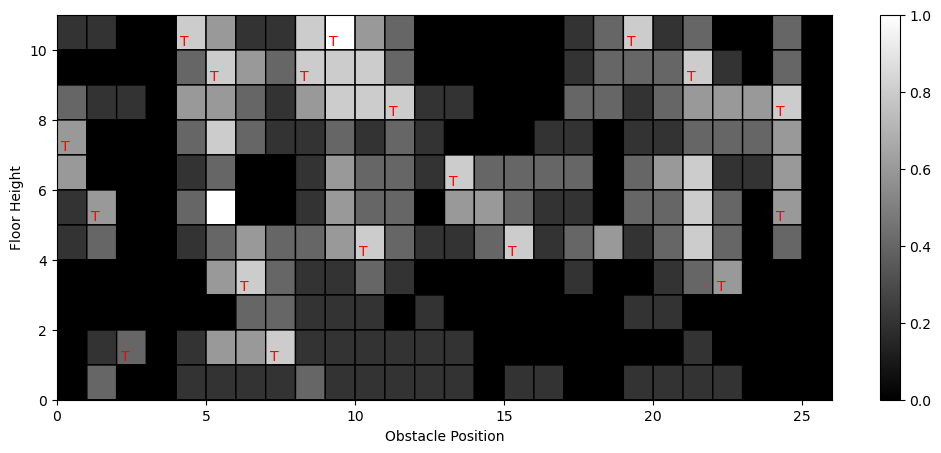

In [ ]:
bss = [32, 64, 128, 256]
bss_results = []

for i, bs in enumerate(tqdm(bss)):
    hyperparams = {'batchsize': bs}

    results_per_sample, results_per_run = test_sampling_strategy(demonstrations, "Random Sampling Agent", validation=False, silent=True, n_runs=5, updates=2500, hyperparameters=hyperparams, redo_fails=i!=0)
    plot_results(results_per_sample, settings, export_path=f'figures/random_batchsize_{bs}.png')
    bss_results.append(results_per_run)

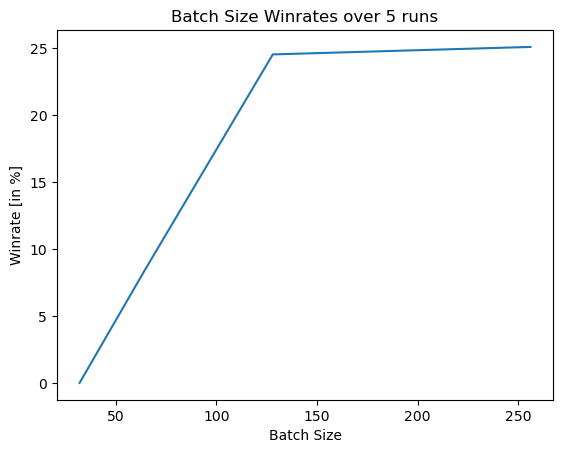

In [ ]:
plot_mean_std(bss, np.array(bss_results)*100, xlab="Batch Size", ylab="Winrate [in %]", title="Batch Size Winrates over 5 runs with 2500 updates")

### Sample Size

  0%|          | 0/12 [00:00<?, ?it/s]

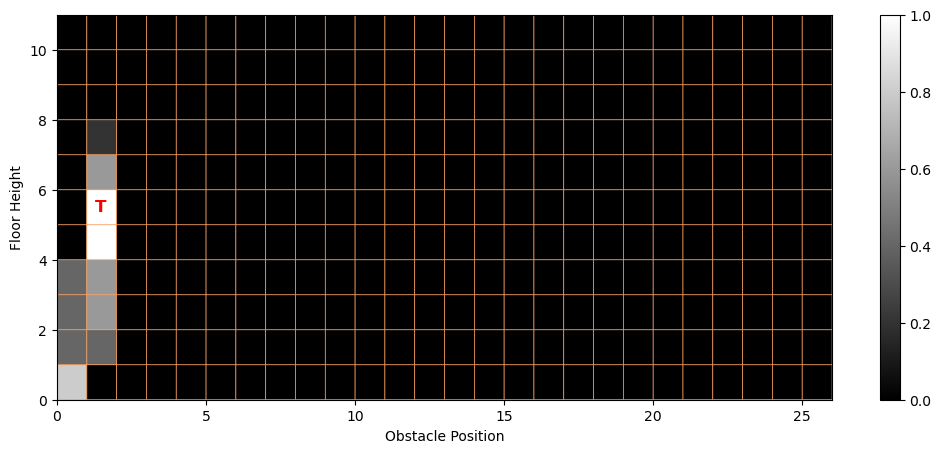

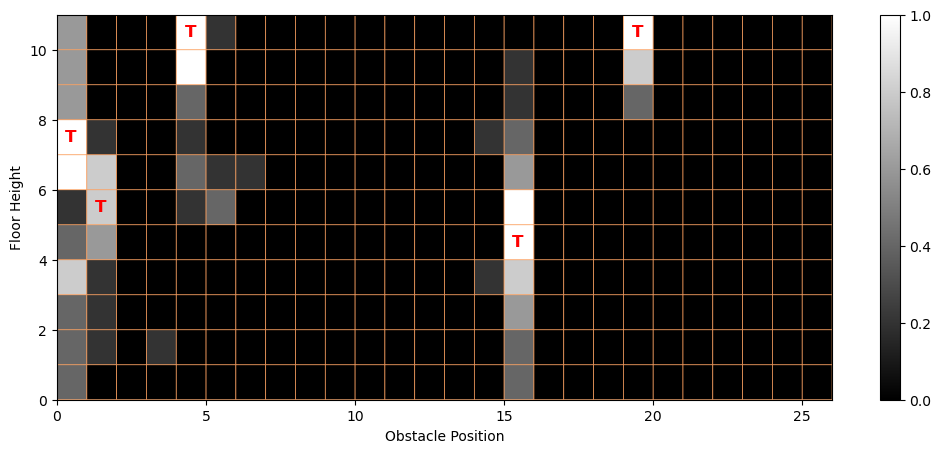

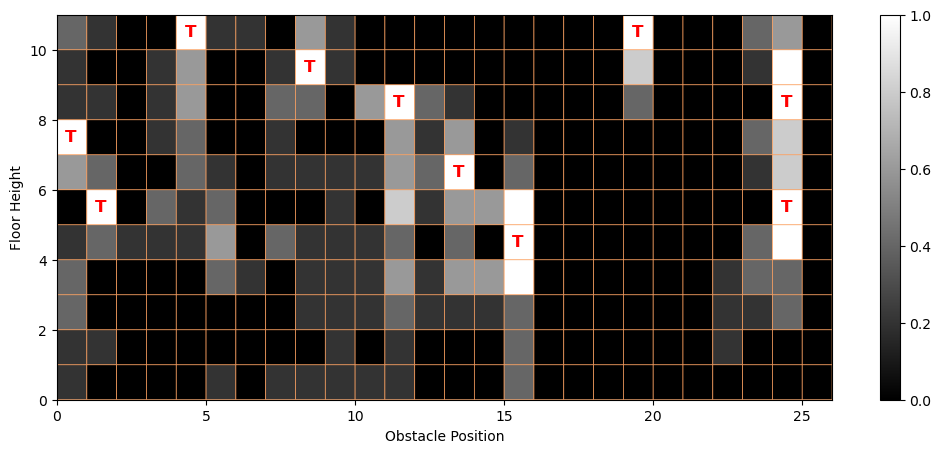

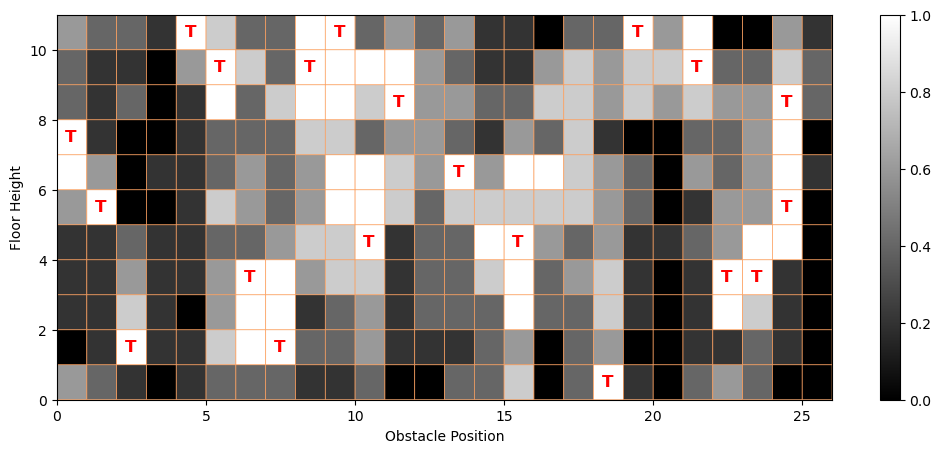

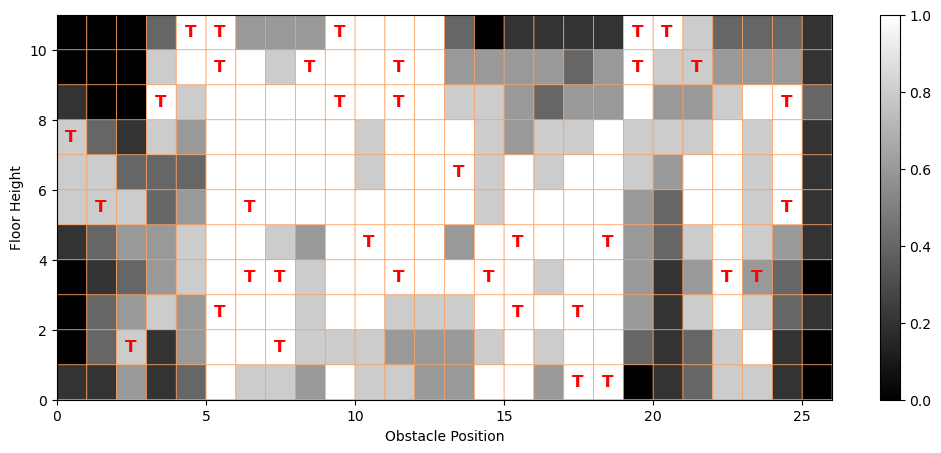

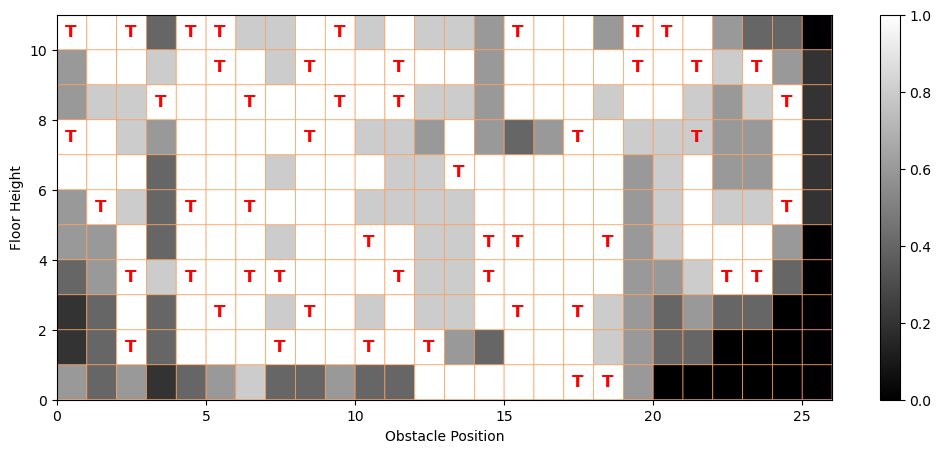

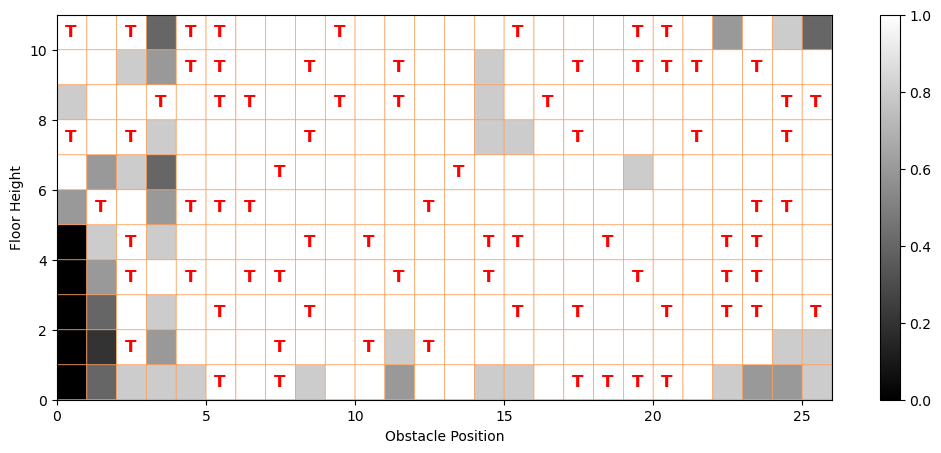

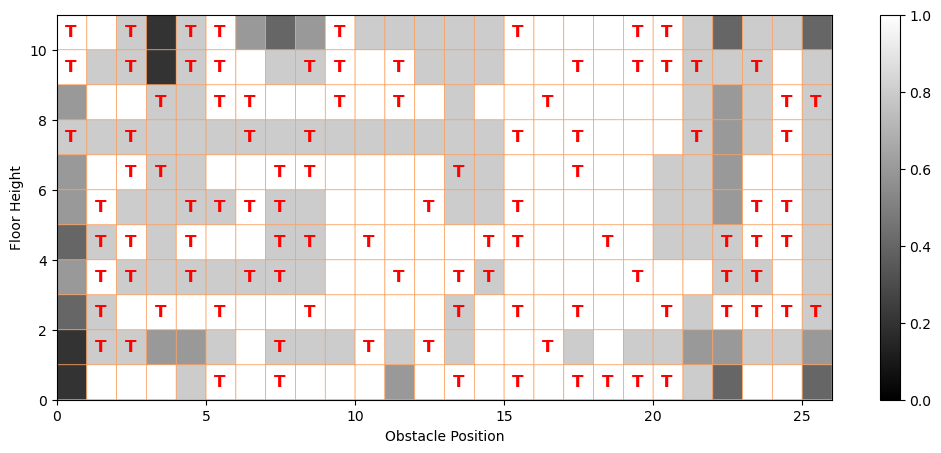

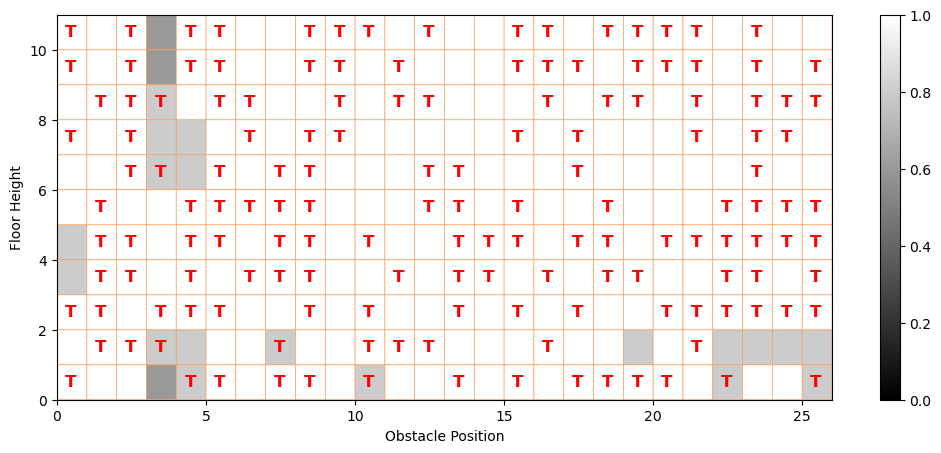

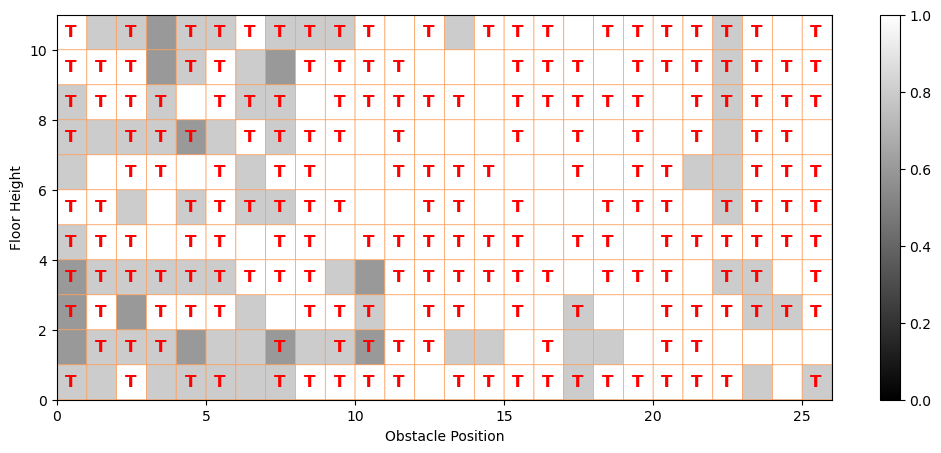

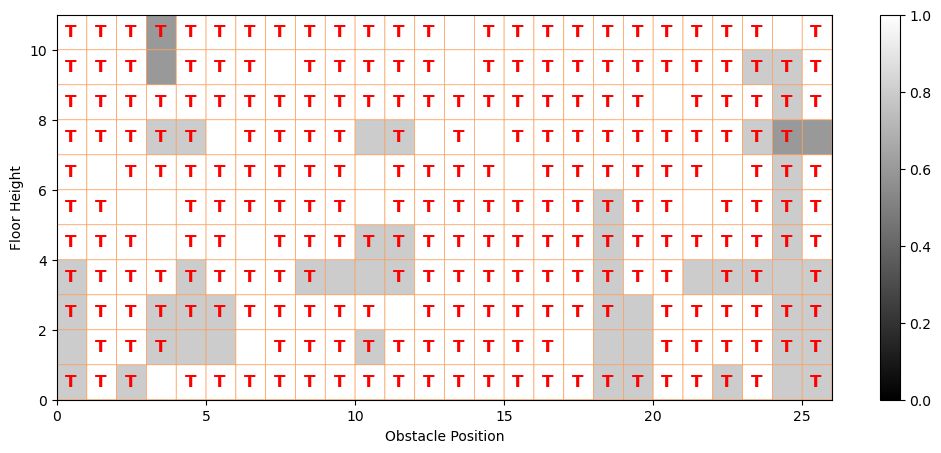

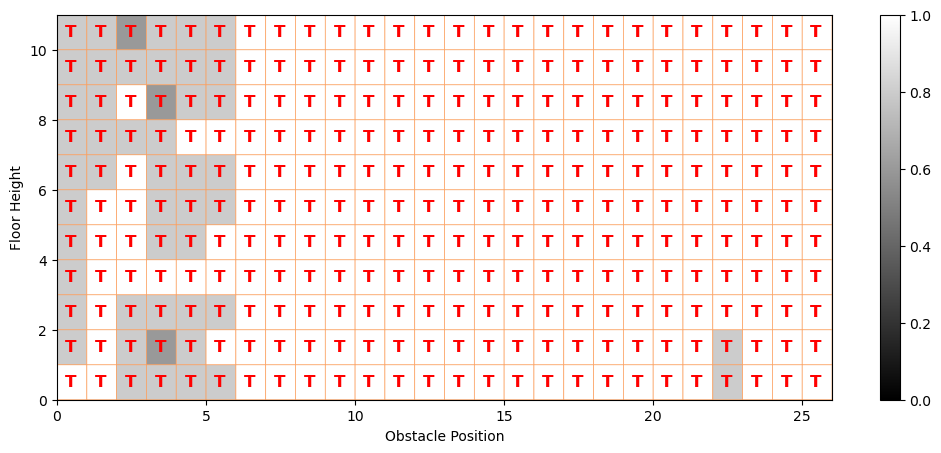

In [94]:

sample_sizes = [1, 5, 10, 20, 35, 50, 75, 100, 150, 200, 250, 286]
sample_results = []
for i,n in enumerate(tqdm(sample_sizes)):
    reset_rng()
    settings = random_settings(n)
    demonstrations = sample_demonstrations(settings, silent=True)
    results_per_sample, results_per_run = test_sampling_strategy(demonstrations, "Random Sampling Agent", validation=False, silent=True, n_runs=5, updates=2500, redo_fails=True)
    plot_results(results_per_sample, settings, export_path=f'figures/random_samples_{n}.png')
    sample_results.append(results_per_run)

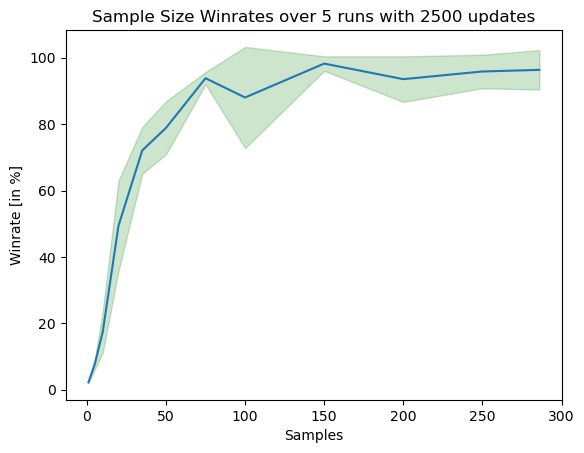

In [95]:
plot_mean_std(sample_sizes, np.array(sample_results)*100, xlab="Samples", ylab="Winrate [in %]", title="Sample Size Winrates over 5 runs with 2500 updates")


## Exporting Agents

In [33]:
lr = 1e-3
batchsize = 128
wd = 1e-5
n_epochs = 200

In [ ]:


exports = [('Random Sampling Agent', rnd_sampling_demonstrations),('Mixed Sampling Agent', mixed_sampling_demonstrations)]

for n, d in exports:
    reset_rng()
    dataset = BufferDataset(d)
    net = AgentNetwork(ACTION_SPACE).to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    loader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    trainer = BCTrainer(net, loader, loss_func, optimizer, validation=False)
    losses, win_rates = trainer.run(n_epochs, show_progress = True)
    agent = Agent(net, n)
    agent.save('200_epochs')

## DQN

In [47]:
def augment_reward(env, reward, action):
    
    if reward == -1: # lost
        return -0.5
    
    if reward == 2 or env.agent_pos_x == env.obstacle_position + env.obstacle_size[0]: # made it over the obstacle
        return 0.25 #625
    if reward == 2 and  env.agent_pos_x < env.obstacle_position + env.obstacle_size[0]:
        return 0.25

    
    reward = 0
    if env.agent_pos_x < env.obstacle_position + env.obstacle_size[0]:
        return 0
    if env.agent_pos_x > env.obstacle_position-15: # anticiption to getting over obstacle
        reward = 0.02
    if env.agent_pos_y > env.floor_height + 1: # incentive to jump
        reward = 0.01
    return reward * min(max(env.agent_pos_x - env.obstacle_position-14, 1),5) *0.1
    #if  env.obstacle_position - 14 < env.agent_pos_x: # already past the point to jump over
    #    #if env.agent_pos_y > env.floor_height + 1:
    #    return 0 # actions do not influence anything anymore so jumping should be avoided
    
    
    
    if action == 1 and reward == 1:
        if env.agent_pos_y == env.floor_height + 1: #grounded
            if env.agent_pos_x + 14 == env.obstacle_position: # optimal
                return 1
            if action == 1: # suboptimal
                return 0
    
    #if env.agent_pos_y > env.floor_height + 1:
    #    return reward
    
    return reward if reward != 1 else reward / env.max_x_position

In [48]:
class DQNNetwork_atari(nn.Module):

    def __init__(self, state_size,num_actions):
        super().__init__()

        self.num_actions = num_actions
        # Network Architecture
        # 4 input image channels, 16 output channels, 8x8 square convolution, stride=4, with relus
        # 16 input channels, 32 output channels, 4x4 square convolution, stride=2, with relus
        # 256 units linear layer, with relus
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(8, 32, 4, stride=2),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1152, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_actions),
        )

    def forward(self, x):
        if len(x.size()) == 3:
            x = x.unsqueeze(dim=1)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [49]:
class DQN_CBSE(nn.Module):

    def __init__(self, state_size, num_actions):
        super().__init__()

        self.num_actions = num_actions
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, num_actions),
        )

    def forward(self, x):
        if len(x.size()) == 3:
            x = x.unsqueeze(dim=1)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [98]:
class DQNTrainer(object):
    def __init__(self, model, target, env, env_configs, batches, batchsize, loss_func, optimizer, gamma=0.99, tau=1e-3):
        self.model = model
        self.target = target
        self.env = env
        self.env_action_space = env.nb_actions
        self.env_configs = env_configs
        self.batches = batches
        self.batchsize = batchsize
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.gamma = gamma
        self.tau = tau
        
    def train(self, dataloader, pbar=None):
        self.model.train()
        
        losses = []
        for i, (states, actions, rewards, next_states, done) in enumerate(dataloader):
            self.optimizer.zero_grad()
            q_p = self.model(states)
            q_t = self.target(next_states).detach()
            
            next_q_p = self.model(next_states).detach()
            next_actions = next_q_p.max(1)[1].unsqueeze(1)
            max_next_q_t = q_t.gather(1, next_actions)
            
            targets = rewards + (self.gamma * (1.0-done)) * max_next_q_t[:, 0]# torch.max(q_t, dim=1)[0]
            predictions = (q_p * actions).sum(dim=1)
            
            loss = self.loss_func(predictions, targets)
            loss.backward(retain_graph=False)
            self.optimizer.step()

            losses.append(loss.item())
            
            if pbar is not None:
                pbar.set_postfix_str(f"[{i+1}/{self.batches}] Loss: {np.mean(losses):.4f}")
            if i+1 == self.batches:
                break
        return losses
        
    
    def eval(self):
        self.model.eval()
        _agent = Agent(self.model)
        _, winrate = evaluate_agent_on_all_episodes(_agent, verbose=False)
        return winrate

    
    def run(self, episodes, buffer, update_after, epsilon_lb=0.01, epsilon_ub=1.0, epsilon_decay=0.995, validation=False, augment_reward_func=None, stop_at_average_winrate=1.0):
        returns = None
        losses = []
        #avg_losses[0] = np.mean(self.eval())
        
        _agent = Agent(self.model)
        _expert = Expert(self.env)
        
        timesteps = 0
        episode_timesteps = []
        winresults = []
        returns = []
        epsilon = epsilon_ub
        
        intermediate_goal_states = [[] for _ in range(len(self.env_configs))]
        furtest_ts = 0
        max_avg_ts = 1
        lookback = 5
        sampled_timesteps = np.zeros((len(self.env_configs),57))
        with tqdm(range(1, episodes+1)) as pbar:
            for e in pbar:
                furtest_ts = np.array([np.argwhere(s_ts > 0).max() if np.sum(s_ts) > 0 else 0 for s_ts in sampled_timesteps])
                if np.all(furtest_ts == furtest_ts.max()):
                    config_idx = np.random.randint(len(self.env_configs))
                else:
                    config_idx = furtest_ts.argmin()
                config = self.env_configs[int(config_idx)]
                done = False
                state = self.env._reset(**config)
                ret = 0
                episode_timestep = 0
                episode_intermediate_goal = []
                sampled_ts = sampled_timesteps[config_idx]
                igs = intermediate_goal_states[config_idx]
                while not done:
                    
                    # action selection
                    if np.random.choice([0,1], p=[1-epsilon,epsilon]):
                        #a = np.random.randint(low=0, high=self.env_action_space, size=1)[0]
                        #a = np.random.choice([0,1], p=[55/56,1/56])
                        a = np.random.choice([0,1], p=[.9,.1])
                        #a = np.random.choice([0,1])
                        #a = _expert.select_action()
                    else:
                        a = _agent.act(state)
                    
                    next_state, reward, done, _ = self.env.step(a)
                    
                    if done:
                        winresults.append(int(reward == 2))
                    
                    #if augment_reward_func is not None:
                    #    reward = augment_reward_func(self.env, reward, a)
                    
                    diff = next_state - state
                    
                    g_min_dist = np.inf
                    if not done:
                        for ts, g in igs:
                            if ts < episode_timestep:
                                continue
                            dist = spatial.distance.cosine(g.flatten(), diff.flatten())#np.sum(np.sqrt(np.square(state - g))) / np.sum(np.ones_like(g))
                            if dist < g_min_dist:
                                g_min_dist = dist
                                reward = ts * 0.1
                        
                        reward -= g_min_dist if g_min_dist < np.inf else 0
                        reward *= 0.15
                        ret += reward
                    #if reward != 0 or np.random.choice([0,1], p=[1-epsilon,epsilon]):
                    
                    #if done or np.random.choice([0,1]):               
                    samples = np.sum(sampled_ts)
                    beta = 1 - (sampled_ts[episode_timestep] / samples if samples else 0)

                    if np.random.choice([0,1], p=[1-beta,beta]):
                        buffer.add(Transition(state, a, reward, next_state, done))
                        sampled_ts[episode_timestep] += 1
                    
                    timesteps += 1
                    episode_timestep += 1
                    state = next_state
                    
                    if timesteps >= update_after and timesteps % update_every == 0:
                        dataset = BufferDataset(buffer)
                        loader = DataLoader(dataset, batch_size=self.batchsize, shuffle=True)
                        loss = np.mean(self.train(loader, pbar))
                        losses.append(loss)
                        self.soft_update()

                    furtest_ts = np.argwhere(sampled_ts > 0).max()
                    if g_min_dist > 0:
                        if furtest_ts == episode_timestep and done: # same as furtest
                            if sampled_ts[furtest_ts] > 1:
                                if done:
                                    winresults.append(1)
                                    igs.append((episode_timestep, diff))
                                    if len(episode_intermediate_goal):
                                        igs.extend(episode_intermediate_goal)
                            else: # current is furtest
                                winresults.append(1)
                                igs.clear()
                                igs.append((episode_timestep, diff))
                                if len(episode_intermediate_goal):
                                    igs.extend(episode_intermediate_goal)
                                furtest_ts = episode_timestep
                                break
                    
                        if episode_timestep % lookback == 0 and episode_timestep != furtest_ts:
                            episode_intermediate_goal.append((episode_timestep, diff))

                episode_timesteps.append(episode_timestep)
                returns.append(ret)
                
                # Decay epsilon
                epsilon = max(epsilon_lb, epsilon * epsilon_decay)# - timesteps/ epsilon_decay)
                

                
                if len(episode_timesteps) > 20:
                    last = max(len(self.env_configs), 10)
                    
                    max_avg_ts = max(max_avg_ts, np.mean(episode_timesteps[-2*last:]))
                    
                    if epsilon - epsilon_lb < 0.5 * (epsilon_ub - epsilon_lb) and np.mean(winresults[-last*2:]) >= stop_at_average_winrate:
                        break
                    
                    pbar.set_description_str(f"[Avg] ETS: {np.mean(episode_timesteps[-last:]):.1f}, R: {np.mean(returns[-last:]):.2f}, WR: {np.mean(winresults[-last:])*100:.1f}%, Eps: {epsilon:0.3f}, IG: {furtest_ts}")
                #if len(losses) > 0:
                #    avg_losses.extend(np.mean(losses))
                #if avg_losses[-1] > 5: # avoid loss exploding
                
                #if e % 200 == 0:
                #    self.hard_update()
        print(timesteps)
        return losses, returns, episode_timesteps
    
    def hard_update(self):
        self.soft_update(tau=1.0)
    
    def soft_update(self, tau=None):
        if tau is None:
            tau = self.tau
        for target_param, local_param in zip(self.target.parameters(), self.model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [99]:
batches = 1
batchsize = 256
n_episodes = 10_000#5_000#5_000
buffer_size = 100_000

lr=1e-3
wd=1e-5

tau = 0.01
gamma = 0.99

epsilon_decay = 0.9995# 100_000
epsilon_ub = 1.0
epsilon_lb = 0.01

update_after = 5000
update_every = 5

use_demonstrations=False

In [100]:
def augment_reward_simple(env, reward, action):
    if reward == 2:
        return 4
    if reward < 0:
        return -5
    return reward / 55
    
    
    
    if reward < 0:#
        return 0
        frames_off = 0
        if env.agent_pos_y < env.obstacle_size[1] + env.floor_height + 1:
            frames_off = env.obstacle_size[1] + env.floor_height + 1 - env.agent_pos_y
        else:
            frames_off = (agent_pos_x - env.obstacle_position - env.obstacle_size[0])
        return -1 * frames_off
    
    if reward == 2: # lost or won
        return 1

    if env.agent_pos_x < env.obstacle_position + env.obstacle_size[0]:
        if env.agent_pos_x > env.obstacle_position-15:
            if env.agent_pos_y > env.floor_height + 1:
                return 0.05

    return 0

In [101]:
def reward_minus_one(env, reward, action):
    if env.done:
        return reward
    
    if env.agent_pos_x >= env.obstacle_position + env.obstacle_size[0]:
        return 0.05
        
    if env.agent_pos_y > env.floor_height + 1:
        return 0.01
    
    return 0

In [102]:
reset_rng()

reward_func = reward_minus_one # reward_minus_one

net = AgentNetwork(ACTION_SPACE).to(device)
target = AgentNetwork(ACTION_SPACE).to(device)

loss_func = nn.MSELoss().to(device)#nn.SmoothL1Loss().to(device) ##nn.MSELoss().to(device)

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

rnd_sampling_settings = optimized_random_settings(n_samples, offset=(3,1), min_distance=2)

dqn_env =  gym_jumping_task.envs.JumpTaskEnv(rendering=False,)

trainer = DQNTrainer(net, target, dqn_env, rnd_sampling_settings, 
                     batches=batches, batchsize=batchsize, 
                     loss_func = loss_func, optimizer=optimizer, 
                     tau=tau, gamma=gamma
)

dqn_buffer = ReplayBuffer(buffer_size)
if use_demonstrations:
    while len(dqn_buffer) < update_after:
        sample_demonstrations(rnd_sampling_settings, dqn_buffer, reward_func, sample_zero_rewards=True, silent=True)
    print(len(dqn_buffer))

In [108]:

losses, returns, episode_timesteps = trainer.run(n_episodes, dqn_buffer, update_after, epsilon_lb=epsilon_lb, epsilon_ub=epsilon_ub, epsilon_decay=epsilon_decay, validation=True, stop_at_average_winrate=0.99)


  0%|          | 0/10000 [00:00<?, ?it/s]

328194


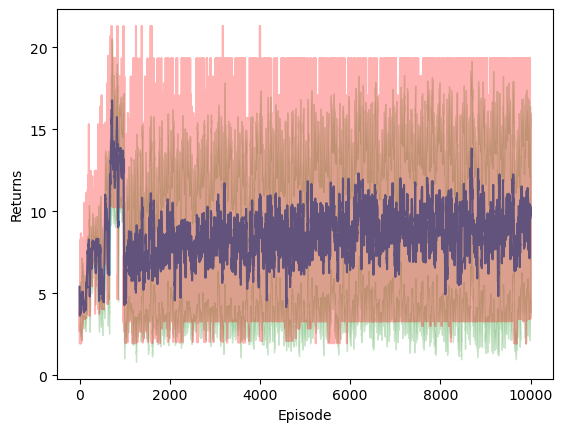

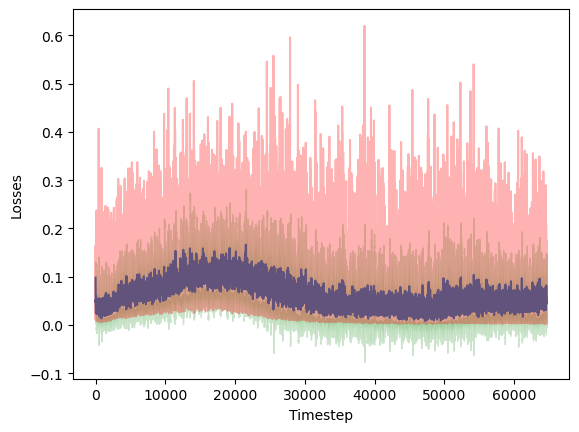

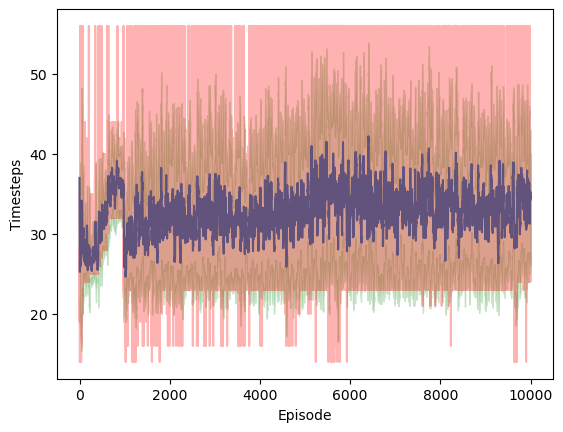

In [109]:
plot(returns, "Episode", "Returns", window=n_samples)
plot(losses, "Timestep", "Losses", window=n_samples)
plot(episode_timesteps, "Episode", "Timesteps", window=n_samples)

In [110]:
agent = Agent(net, "DQN Random")
results, winrate = evaluate_agent_on_all_episodes(agent, verbose=rendering)
print(winrate)

DQN Random


  0%|          | 0/286 [00:00<?, ?it/s]

0.08391608391608392


In [111]:
agent.save("20000eps")

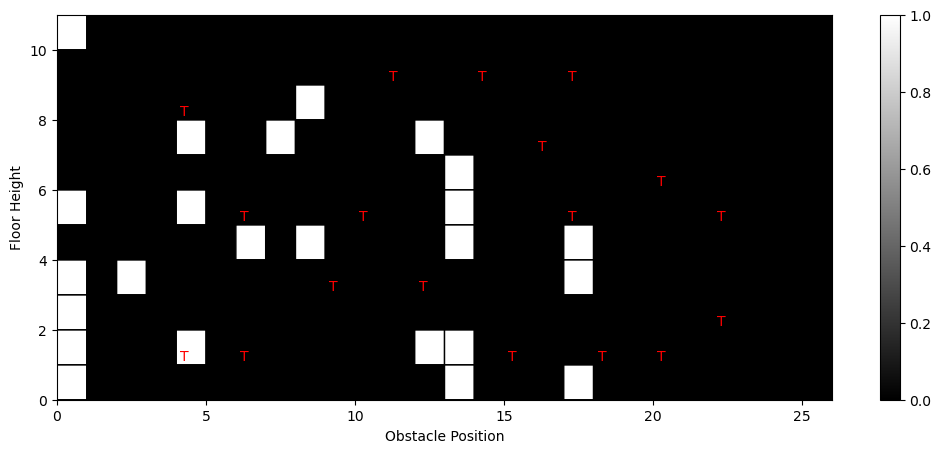

In [112]:
plot_results(results, rnd_sampling_settings)

# Visualizations

In [ ]:

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [35]:
imports = [('DQN Random', '20000eps'), ('Random Sampling Agent', '200_epochs'), ('Mixed Sampling Agent', '200_epochs')]
test_settings = [{'floor_height': 5, 'obstacle_position': 27}, {'floor_height': 2, 'obstacle_position': 32},  {'floor_height': 4, 'obstacle_position': 38}]

In [36]:

rnd_sampling_settings = restricted_random_settings(n_samples, offset=(3,1), min_distance=2)

DQN Random


  0%|          | 0/286 [00:00<?, ?it/s]

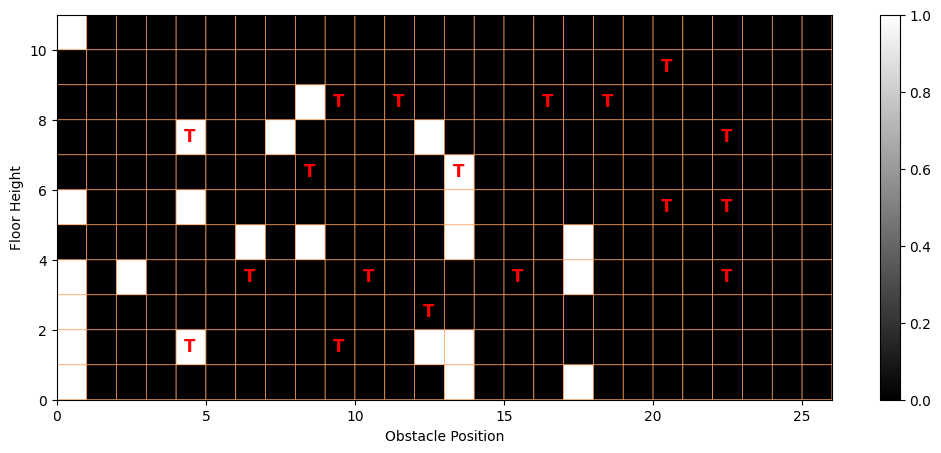

Random Sampling Agent


  0%|          | 0/286 [00:00<?, ?it/s]

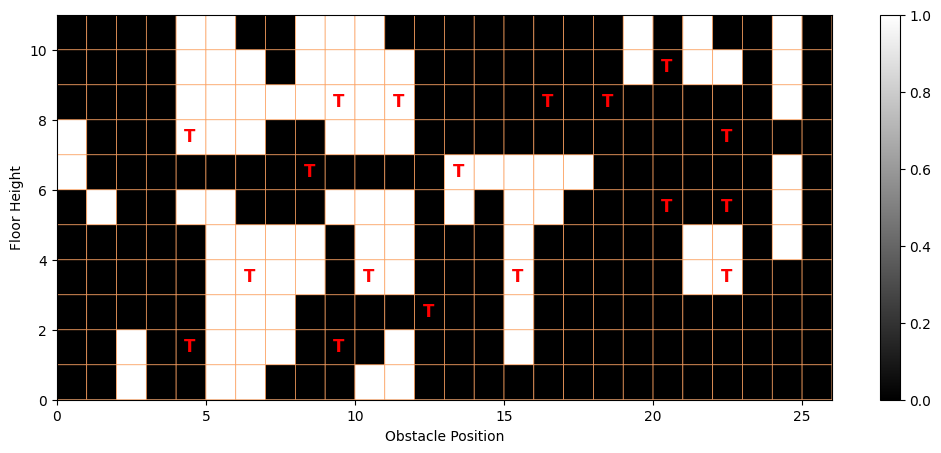

Mixed Sampling Agent


  0%|          | 0/286 [00:00<?, ?it/s]

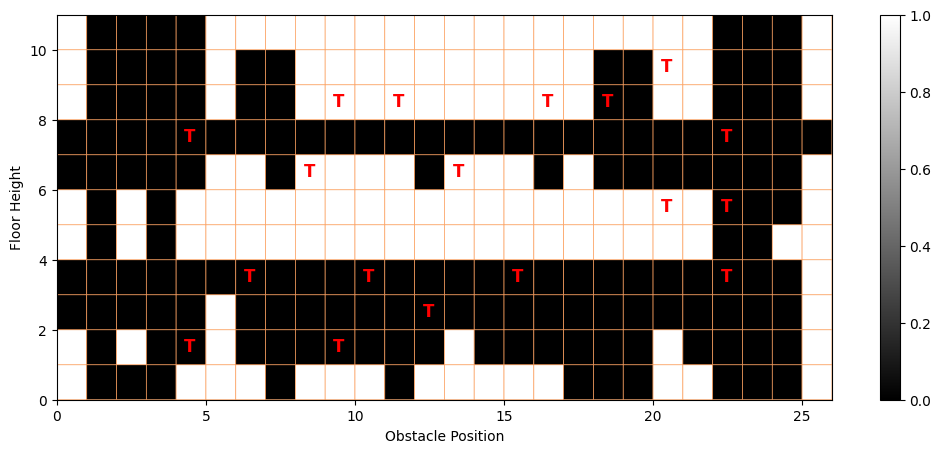

In [37]:
agents = {}
for (name, info) in imports:
    net = AgentNetwork(ACTION_SPACE).to(device)
    agent = Agent(net, name)
    agent.load(info)
    net.eval()
    
    results, winrate = evaluate_agent_on_all_episodes(agent, verbose=rendering)
    
    plot_results(results, rnd_sampling_settings)
    
    agents[name] = net


In [75]:
print(rnd_sampling_settings)

[{'floor_height': 5, 'obstacle_position': 15}, {'floor_height': 10, 'obstacle_position': 33}, {'floor_height': 10, 'obstacle_position': 18}, {'floor_height': 7, 'obstacle_position': 14}, {'floor_height': 4, 'obstacle_position': 29}, {'floor_height': 9, 'obstacle_position': 22}, {'floor_height': 6, 'obstacle_position': 27}, {'floor_height': 8, 'obstacle_position': 25}, {'floor_height': 5, 'obstacle_position': 38}, {'floor_height': 8, 'obstacle_position': 38}, {'floor_height': 4, 'obstacle_position': 24}, {'floor_height': 9, 'obstacle_position': 35}, {'floor_height': 10, 'obstacle_position': 23}, {'floor_height': 1, 'obstacle_position': 16}, {'floor_height': 3, 'obstacle_position': 36}, {'floor_height': 3, 'obstacle_position': 20}, {'floor_height': 9, 'obstacle_position': 19}, {'floor_height': 1, 'obstacle_position': 21}]


# UMAP

In [78]:
representations = []
metadata = []

frame_range = 5

net = list(agents.values())[2]

for i, setting in enumerate(all_sample_settings):
    demonstrations = sample_demonstrations([setting], silent=True)
    jump_frame = np.argmax([d.action for d in demonstrations])
    loader = DataLoader(BufferDataset(demonstrations), batch_size=1, shuffle=False)
    first_jump = True
    for j, (state, action, _, next_state, _) in enumerate(loader):
        if j < jump_frame - frame_range or j > jump_frame + frame_range:
            continue
        
        def forward(net, x):
            x = torch.relu(net.c1(x))
            x = net.s2(x)
            x = torch.relu(net.c3(x))
            x = net.s4(x)
            x = torch.relu(net.c5(x))
            x = torch.flatten(x, 1)
            return x
        
        rep = forward(net, state).detach()
        pred_action = int(torch.argmax(net(state).detach()).squeeze().cpu().numpy())
        
        if first_jump and pred_action:
            first_jump = False
        else: 
            pred_action = 0
        rep = rep.squeeze().cpu().numpy()
        action = int(torch.argmax(action.detach()).squeeze().cpu().numpy())
        
        if action or pred_action or True:
            representations.append(rep)
            metadata.append([i, j - jump_frame, action, pred_action])
representations = np.array(representations)
metadata = np.array(metadata)

In [79]:
print(representations.shape)

(2981, 120)


In [80]:
reducer = umap.UMAP(random_state=DEFAULT_SEED, metric='cosine', n_neighbors=75)
reducer.fit(representations)

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=75, random_state=1468, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: >

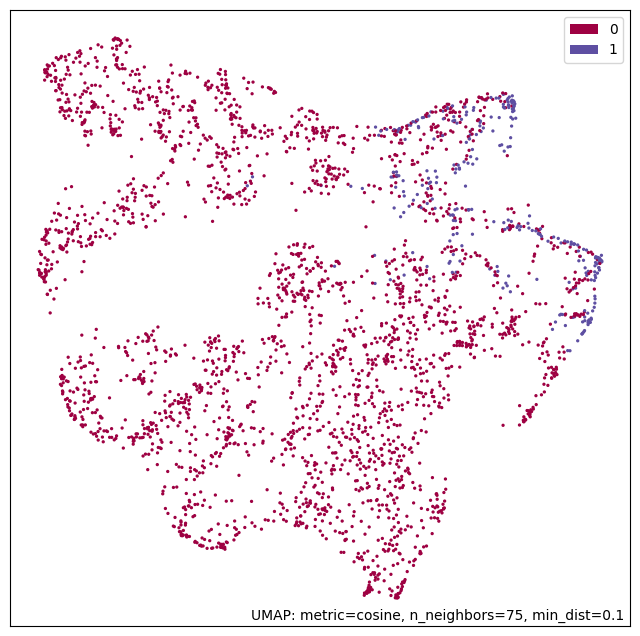

In [81]:
umap.plot.points(reducer, metadata[:, 2])

<Axes: >

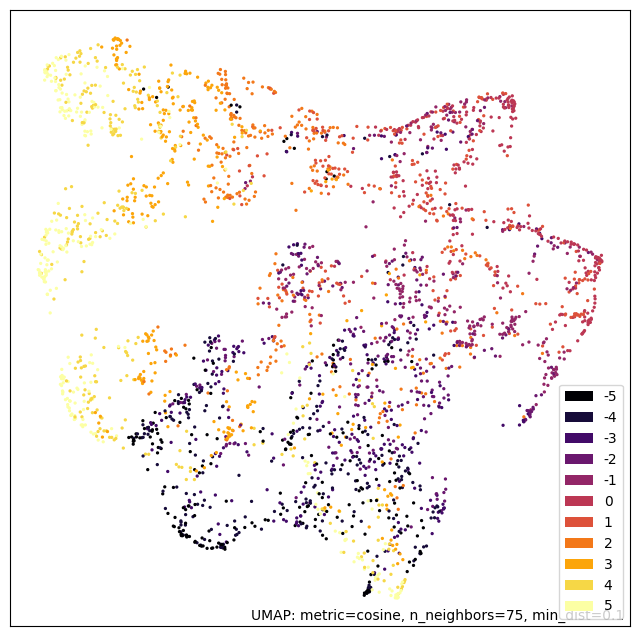

In [82]:
umap.plot.points(reducer, metadata[:, 1], color_key_cmap='inferno')

<Axes: >

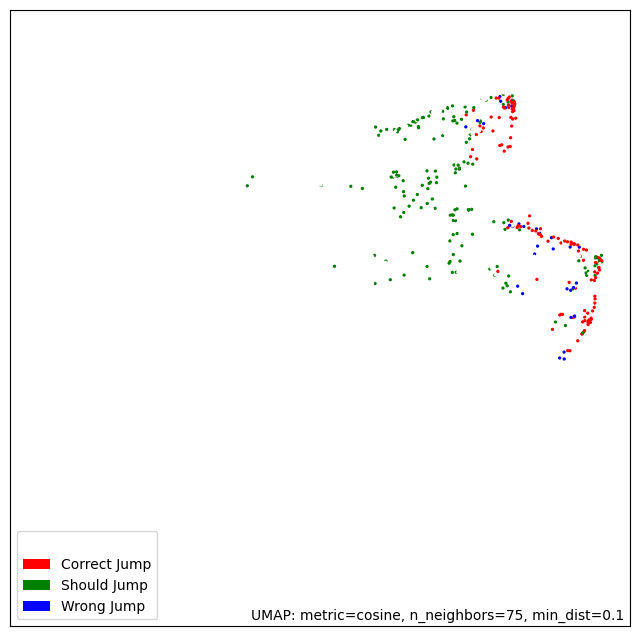

In [83]:
explain = ['Should Jump' if t_a and not p_a else ('Correct Jump' if t_a and p_a else ('Wrong Jump' if p_a and not t_a else "")) for i, f, t_a, p_a in metadata]

umap.plot.points(reducer, np.array(explain), color_key=['r', 'g', 'b'] if "" not in explain else ['white', 'r', 'g', 'b'])

In [171]:
demonstrations = []
for t in test_settings: 
    demonstrations.append(sample_demonstrations([t]))

  0%|          | 0/1 [00:00<?, ?it/s]

Transitions: 56


  0%|          | 0/1 [00:00<?, ?it/s]

Transitions: 56


  0%|          | 0/1 [00:00<?, ?it/s]

Transitions: 56


In [172]:
def to_greyscale(image):
    image = torch.tensor(image).float()
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    image = image[:,:,:,1].unsqueeze(-1)
    image = torch.moveaxis(image, -1, 1)
    return image

def predict(image):
    image_shapes = [image.shape[-3], image.shape[-1]]
    if 1 not in image_shapes and 3 in image_shapes:
        image = to_greyscale(image)
    logits = model(image)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


In [ ]:

explainer = lime_image.LimeImageExplainer(random_state=42,)
explanations = []

for name, model in agents.items():
    for d in demonstrations:
        for i, (state, action, _, _, _) in enumerate(BufferDataset(d)):
            action = torch.argmax(action).item()
            if i == 0 or action == 1:
                state = torch.moveaxis(state.repeat(3, 1, 1).detach(), 0, 2).double().numpy()
                explanation = explainer.explain_instance(
                    state,
                    predict,
                    top_labels=2,
                    num_samples=50,
                    labels=[0,1]
                )
                
                explanations.append((name, i, model, state, action, explanation))

                prev_frame = i -1 
        for i, (state, action, _, _, _) in enumerate(BufferDataset(d)):
            if i == prev_frame:
                action = torch.argmax(action).item()
                state = torch.moveaxis(state.repeat(3, 1, 1).detach(), 0, 2).double().numpy()
                explanation = explainer.explain_instance(
                    state,
                    predict,
                    top_labels=2,
                    num_samples=50,
                    labels=[0,1]
                )
                print(name)
        
                explanations.insert( len(explanations)-1,(name, i, model, state, action, explanation))


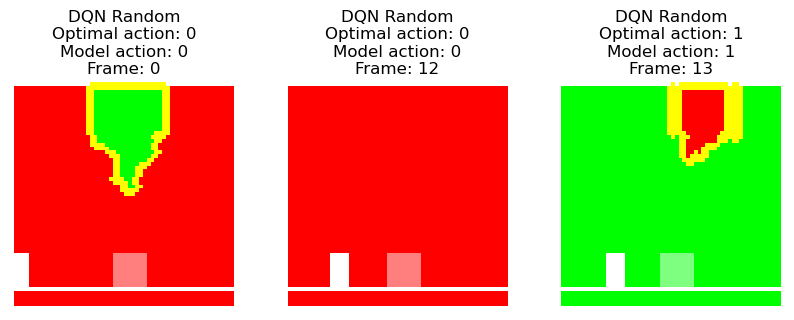

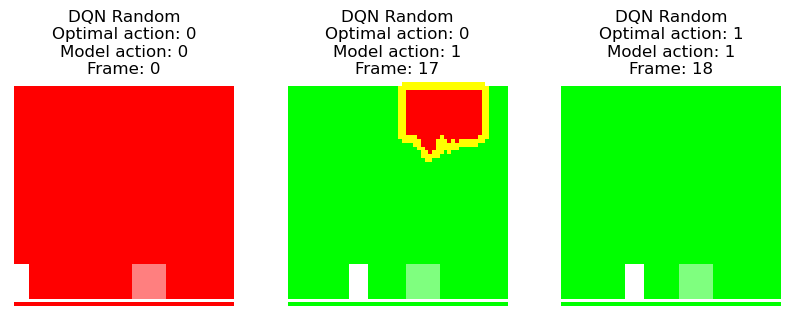

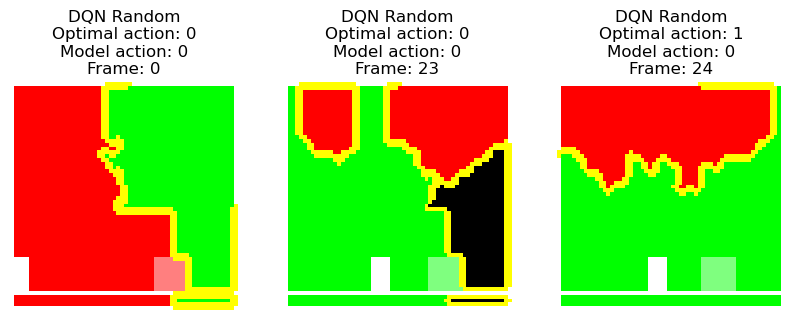

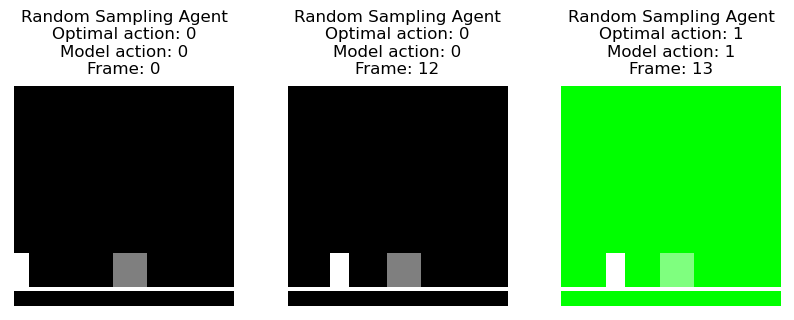

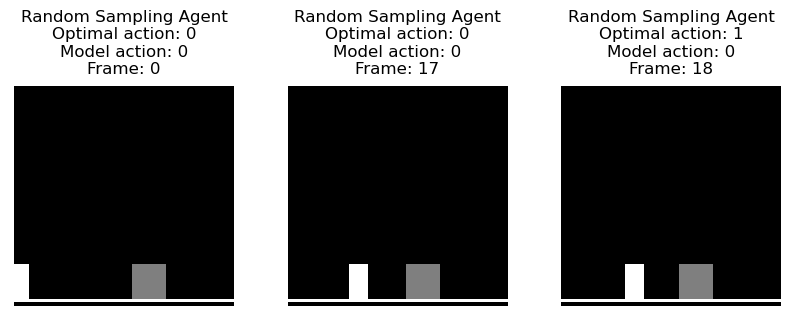

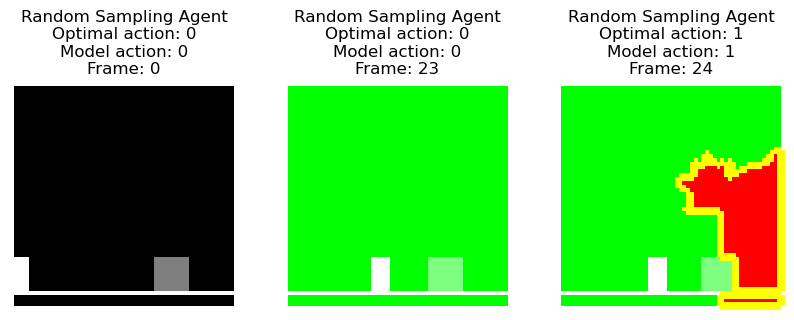

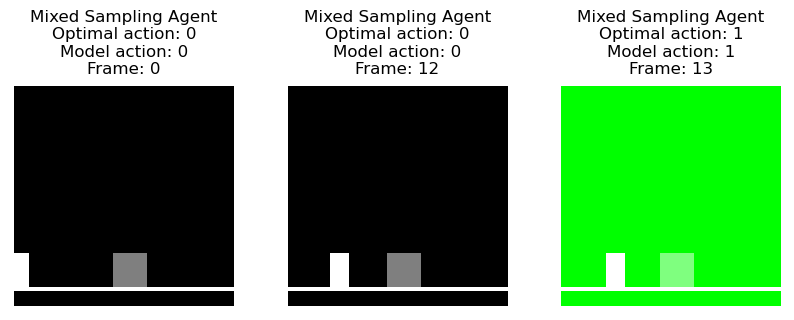

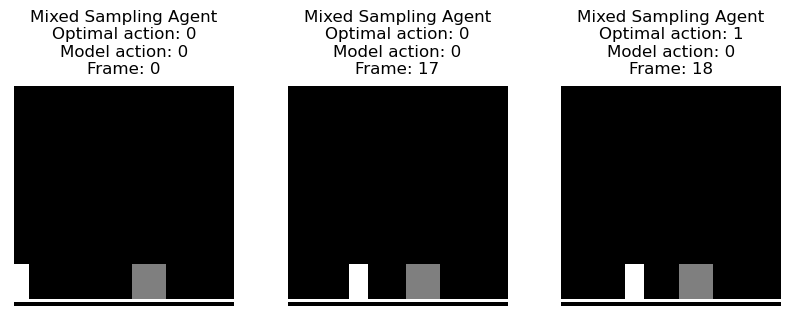

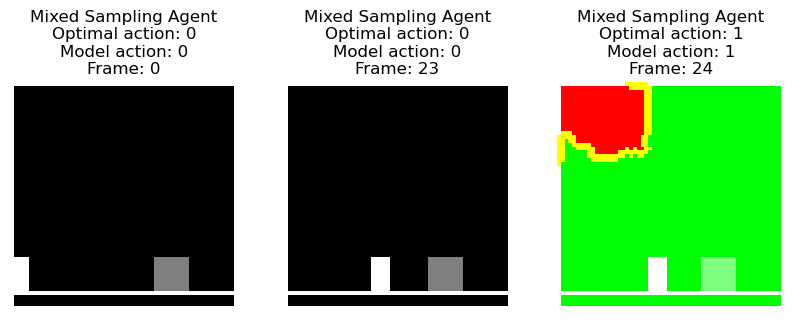

In [228]:

rows = len(explanations)//3
cols = 3
#fig = P.figure(figsize=(rows, cols))
for i, (name, f, model, X, y, (e)) in enumerate(explanations):
    
    
    pred = np.argmax(predict(X))
    image, mask = e.get_image_and_mask(
        1,
        positive_only=False,
        num_features=3,
        hide_rest=False,
        min_weight=1e-4
    )
    
    
    if i % 3 == 0:
        fig = P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
        
    P.subplot(1, cols, (i%3)+1)
    #plt.gca().invert_yaxis()
    #plt.imshow(X, origin='lower')
    P.axis('off')
    P.imshow(mark_boundaries(image, mask), origin='lower', alpha=1.0)

    P.title(f'{name}\nOptimal action: {y}\nModel action: {pred}\nFrame: {f}')
    
    
    if i % 3 == 3:
        P.show()
    
    
